In [1]:
import joblib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import xarray as xr
from matplotlib.lines import Line2D
from pandas import Series, DataFrame, read_csv
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from icefreearcticml.icefreearcticml.constants import (
    VAR_LEGEND_ARGS,
    MODEL_COLOURS,
    MODEL_NAMES,
    VARIABLES,
    VAR_YLABELS,
    VAR_YLIMITS,
)
from icefreearcticml.icefreearcticml.utils.trainconfig import TrainConfig
from icefreearcticml.icefreearcticml.utils.liang import (
    LiangConfig,
    calculate_all_liang_flows,
    plot_liang_tau_avgs,
)
from icefreearcticml.icefreearcticml.utils.data import (
    read_model_data_all,
    add_all,
)
from icefreearcticml.icefreearcticml.utils.utils import (
    get_train_test_ensembles,
    calculate_first_icefree_year,
    plot_variable,
    get_melt,
)
from icefreearcticml.icefreearcticml.utils.output import (
    ModelData,
    Output,
)
from icefreearcticml.icefreearcticml.taylortransformer.pipeline import (
    TaylorFormerPipeline,
)
from icefreearcticml.icefreearcticml.taylortransformer.utils import (
    prepare_data,
    generate_emulation,
)

In [ ]:
X_VARS = ("tas", "wsiv", "oht_atl", "oht_pac")
MODELS = [
    "EC-Earth3",
    "CESM2",
    "MPI-ESM1-2-LR",
    "CanESM5",
    "ACCESS-ESM1-5",
    "all",
]
VARS = ["ssie", "tas", "wsiv", "oht_atl", "oht_pac"]

In [5]:
model_data = read_model_data_all(f"./icefreearcticml/data")

### Precompute

In [ ]:
ice_free_year_ds_path = "./icefreearcticml/outputs/ice_free_year_ds.nc"
bias_ds_path = "./icefreearcticml/outputs/bias_ds.nc"

ice_free_year_ds = xr.open_dataset(ice_free_year_ds_path)
bias_ds = xr.open_dataset(bias_ds_path)

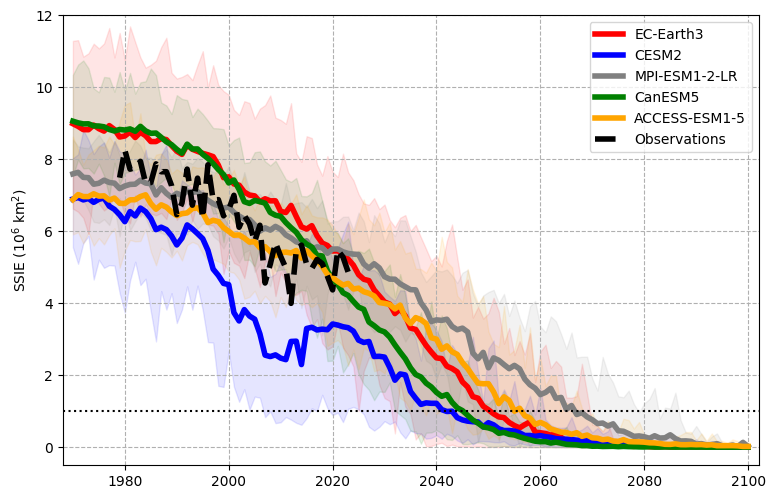

In [4]:
all_var_data = model_data["ssie"]

fig,ax = plt.subplots(1,1,figsize=(8,5))
for i, (model_name, var_data) in enumerate(all_var_data.items()):
    if model_name not in ("all"):
        if model_name == "Observations":
            ax.plot(var_data.index, var_data,'k--', linewidth=4, label=model_name)
        else:
            ax.plot(
                var_data.index, var_data.mean(axis=1), '-',
                color=MODEL_COLOURS[model_name], linewidth=4, label=model_name,
            )
            ax.fill_between(
                var_data.index, var_data.min(axis=1), var_data.max(axis=1), color=MODEL_COLOURS[model_name], alpha=0.1,
            )
ax.grid(linestyle='--')
# ax.set_ylabel(ylabel, fontsize=12)
# ax.tick_params(labelsize=5)
ax.set_ylabel(VAR_YLABELS["ssie"])
ax.axhline(y=1, ls=":", color="black")
ax.legend()
ax.axis(xmin=np.datetime64('1968-01-01'), xmax=np.datetime64('2102-01-01'), **VAR_YLIMITS["ssie"])
fig.subplots_adjust(left=0.08,bottom=0.05,right=0.95,top=0.95,hspace=0.2,wspace=0.2)

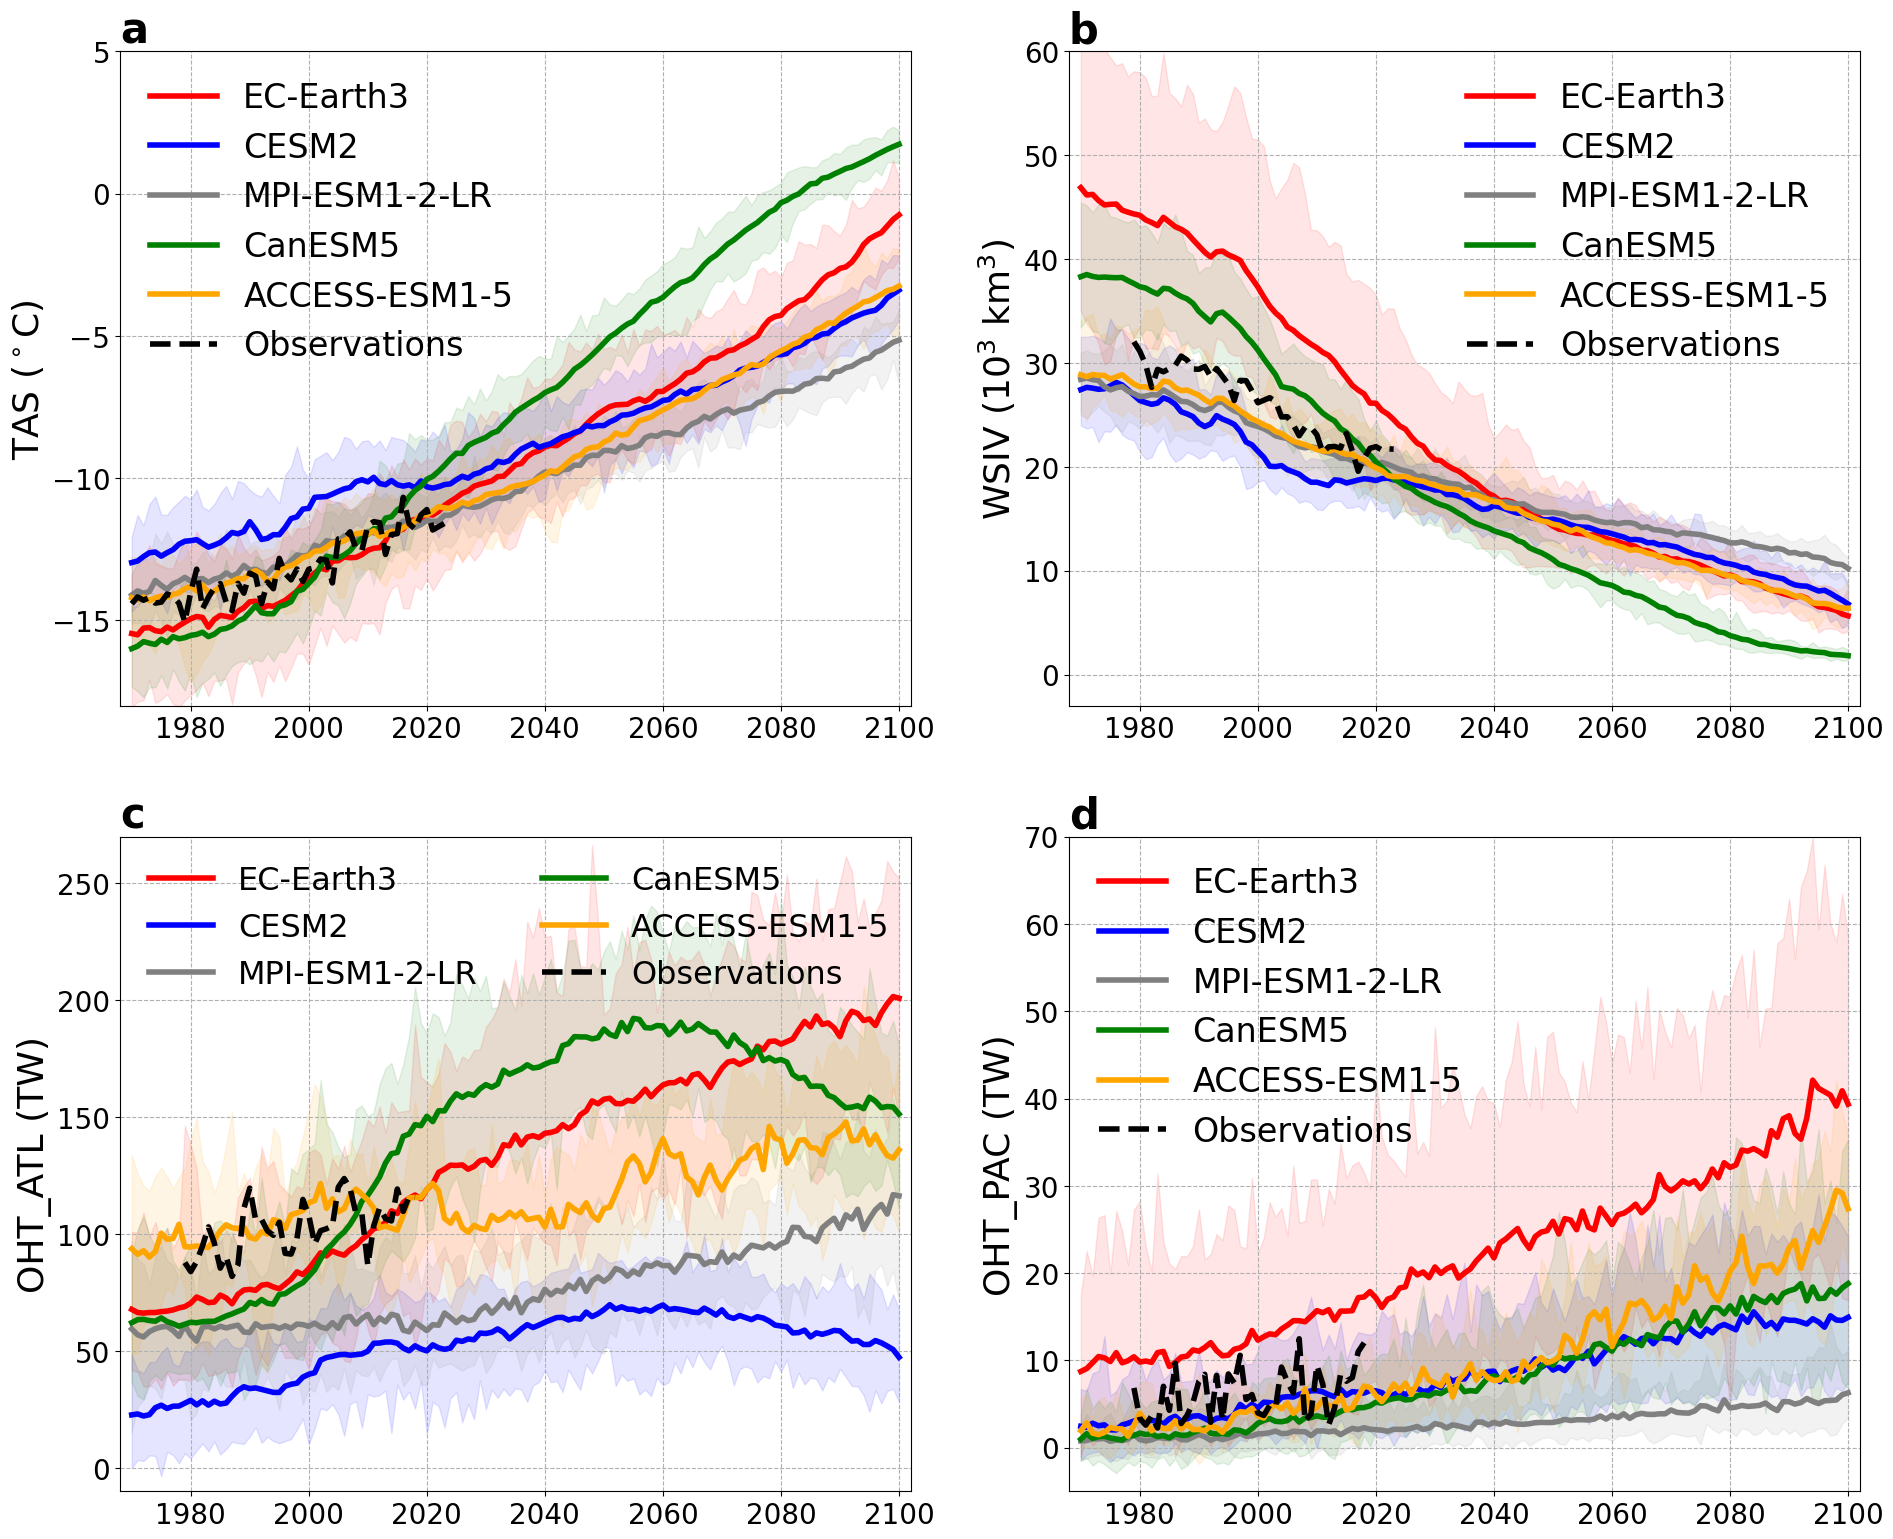

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(20,16))
axes = axes.flatten()

for i, var in enumerate(x_vars):
    ax = axes[i]
    plot_variable(ax, var, model_data[var], VAR_YLABELS[var], i)

fig.subplots_adjust(left=0.08,bottom=0.05,right=0.95,top=0.95,hspace=0.2,wspace=0.2)

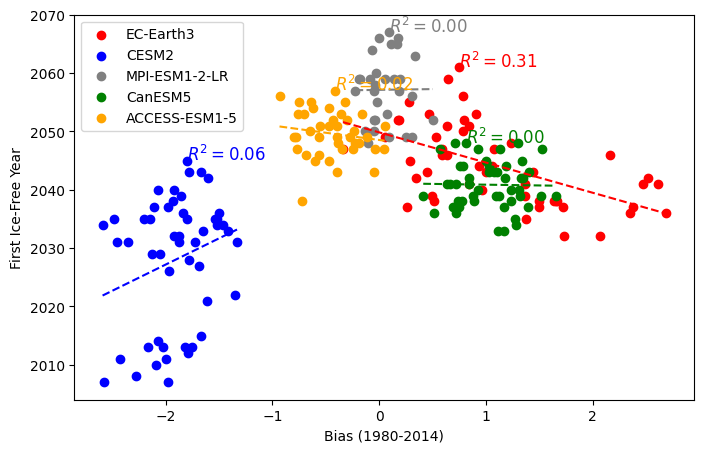

In [57]:
fig,ax = plt.subplots(1,1,figsize=(8,5))

var = "ssie"
for model in MODEL_NAMES:
    x = bias_ds[f"{var}_bias"].sel(ensemble=bias_ds[f"{var}_bias"].ensemble.str.contains(model)).values
    y = ice_free_year_ds.sel(ensemble=ice_free_year_ds.ensemble.str.contains(model))["ice_free_years"].dt.year.values

    fit = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))

    ax.scatter(x, y, c=MODEL_COLOURS[model], label=model)

    predict_x = np.linspace(x.min(), x.max())
    predict_y = fit.predict(predict_x.reshape(-1, 1))

    ax.plot(predict_x, predict_y, color=MODEL_COLOURS[model], linestyle="--")
    r2 = fit.score(x.reshape(-1, 1), y.reshape(-1, 1))

    text_y = y.max()
    text_x = x[y.argmax()]

    ax.text(text_x, text_y, f'$R^2 = {r2:.2f}$', fontsize=12, color=MODEL_COLOURS[model]) 


    ax.legend()
    ax.set_xlabel("Bias (1980-2014)", fontsize=10)
    ax.set_ylabel("First Ice-Free Year", fontsize=10)

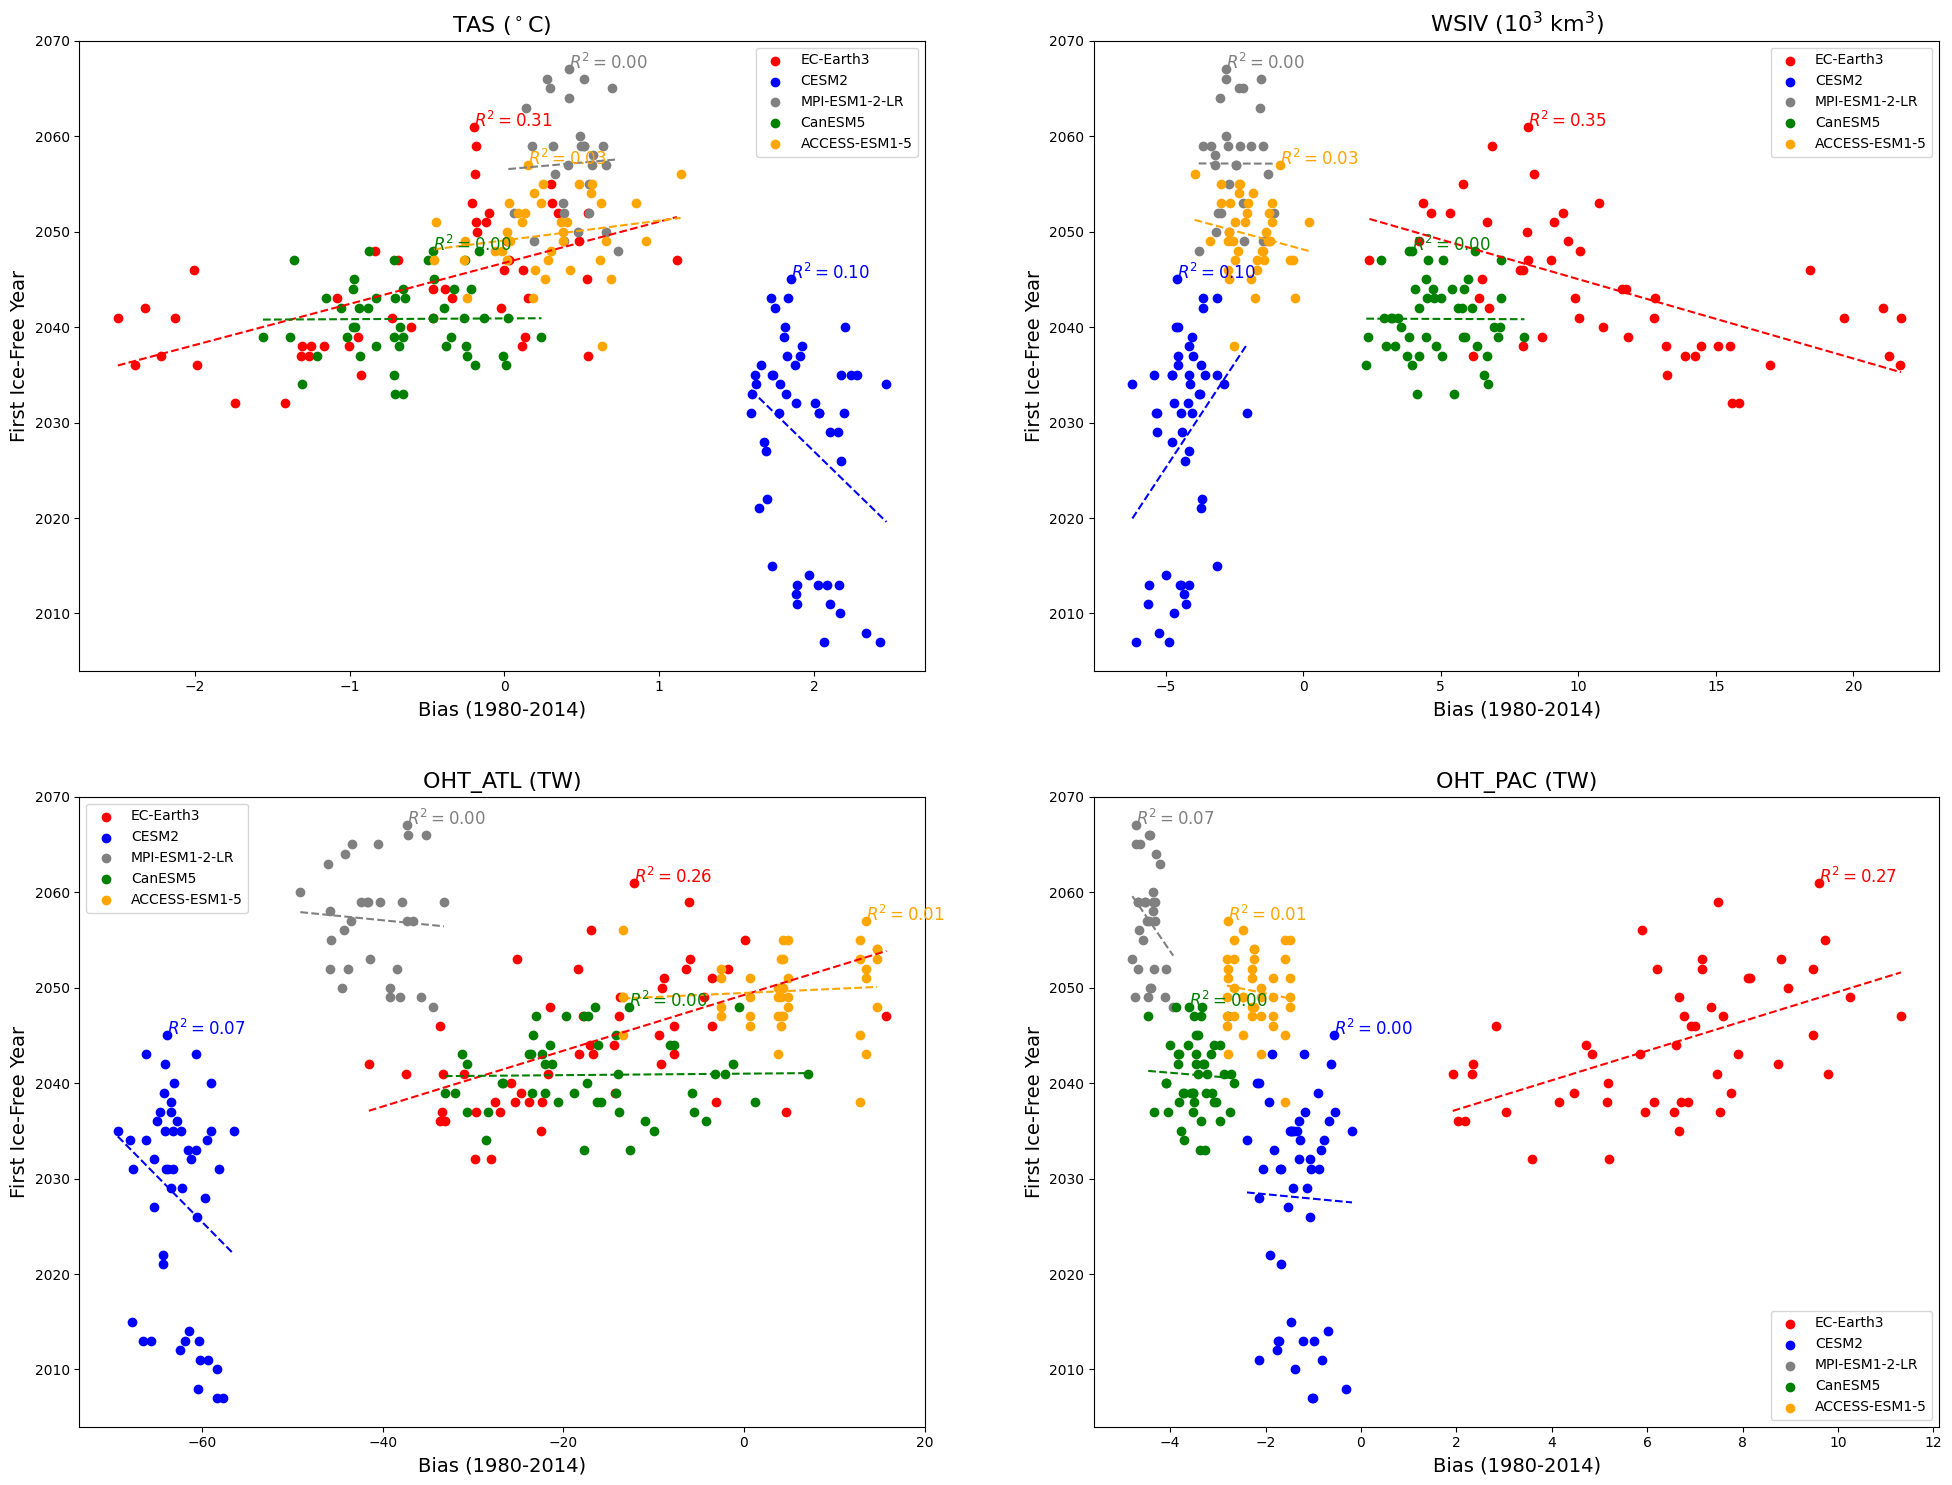

In [58]:
fig,axes = plt.subplots(2,2,figsize=(24,18))

for i, ax in enumerate(axes.flatten()):
    var = x_vars[i]
    for model in MODEL_NAMES:
        x = bias_ds[f"{var}_bias"].sel(ensemble=bias_ds[f"{var}_bias"].ensemble.str.contains(model)).values
        y = ice_free_year_ds.sel(ensemble=ice_free_year_ds.ensemble.str.contains(model))["ice_free_years"].dt.year.values

        fit = LinearRegression().fit(x.reshape(-1, 1), y.reshape(-1, 1))

        ax.scatter(x, y, c=MODEL_COLOURS[model], label=model)

        predict_x = np.linspace(x.min(), x.max())
        predict_y = fit.predict(predict_x.reshape(-1, 1))

        ax.plot(predict_x, predict_y, color=MODEL_COLOURS[model], linestyle="--")
        r2 = fit.score(x.reshape(-1, 1), y.reshape(-1, 1))

        text_y = y.max()
        text_x = x[y.argmax()]

        ax.text(text_x, text_y, f'$R^2 = {r2:.2f}$', fontsize=12, color=MODEL_COLOURS[model]) 


    ax.legend()
    ax.set_title(VAR_YLABELS[var], fontsize=16)
    ax.set_xlabel("Bias (1980-2014)", fontsize=14)
    ax.set_ylabel("First Ice-Free Year", fontsize=14)

### Emergent Constraints

In [61]:
def get_constrained_diff(row: Series) -> float:
    return (row["raw_mean"] - row["Yc"]) / row["Yc"]

def get_ensemble_dfs(
        ec_res: DataFrame,
        n_members: int = 50,
        std_lower: int = -3,
        std_upper: int = 3,
        clip: bool = True,
    ) -> tuple[DataFrame]:
    x = ec_res["proj_end"]
    y_unconstrained = ec_res["raw_mean"]
    y_constrained = ec_res["Yc"]

    unconstrained_std = ec_res.filter(regex="Y_").std(axis=1)
    sigma_c = ec_res["sigma"].map(np.sqrt)

    n_times = len(x)
    std_multipliers = np.random.uniform(std_lower, std_upper, size=n_members)
    std_matrix = np.tile(std_multipliers, (n_times, 1))

    ensemble_c = y_constrained.values[:, None] + sigma_c.values[:, None] * std_matrix
    ensemble_uc = y_unconstrained.values[:, None] + unconstrained_std.values[:, None] * std_matrix
    ensemble_c_df = DataFrame(ensemble_c, index=x, columns=range(n_members))
    ensemble_uc_df = DataFrame(ensemble_uc, index=x, columns=range(n_members))
    if clip:
        ensemble_c_df = ensemble_c_df.clip(lower=0)
        ensemble_uc_df = ensemble_uc_df.clip(lower=0)

    return ensemble_c_df, ensemble_uc_df

def get_uncertainity_reduction(row: Series) -> float:
    uc_std = row.filter(regex="Y_").std()
    c_std = np.sqrt(row["sigma"])
    return (uc_std - c_std) / uc_std

def plot_corr_coeff(ec_res: DataFrame, ax: plt.Axes, label: str) -> None:
    ax.plot(ec_res["proj_end"], ec_res["r"], lw=2, label=label)
    ax.set_xlabel("5 Year Window End")
    ax.set_ylabel("Correlation Coefficient")

def window_regression_plot(ax: plt.Axes, x_var: str, y_var: str, row: dict) -> None:
    hist_start = row["hist_start"]
    hist_end = row["hist_end"]
    proj_start = row["proj_start"]
    proj_end = row["proj_end"]

    slope, intercept = row["model_res"]
    sigma = row["sigma"]
    Xo = row["Xo"]
    constrained_y = row["Yc"]

    x = [value for key, value in row.items() if "X_" in key]
    y = [value for key, value in row.items() if "Y_" in key]
    x_bar = np.mean(x)
    y_bar = row["raw_mean"]

    for i, (xi, yi) in enumerate(zip(x, y)):
        model_name = MODEL_NAMES[i]
        ax.scatter(xi, yi, label=model_name, color=MODEL_COLOURS[model_name], zorder=5)

    x_line = np.linspace(min(x), max(x), 100)
    y_line = y_bar + slope * (x_line - x_bar)
    y_ci_low = y_line - (sigma * 1.65)
    y_ci_high = y_line + (sigma * 1.65)
    ax.plot(x_line, y_line, ls='-', color="orange", linewidth=2) # , label=f'Regression'
    ax.fill_between(x_line, y_ci_low, y_ci_high, color='orange', alpha=0.2) # , label='95% CI'

    ax.axhline(y=constrained_y, color='blue', linestyle='--', lw=2) # label=f'Constrained Y', 
    ax.axhline(y=y_bar, color='red', linestyle='--', lw=2) # , label=f'Original Y', 
    ax.axvline(x=Xo, color='black', linestyle='--', lw=2) # , label=f'Mean Observation',

    ax.set_xlabel(f"{x_var.upper()} ({hist_start} - {hist_end})")
    ax.set_ylabel(f"{y_var.upper()} ({proj_start} - {proj_end})")
    ax.legend()

def window_prob_density(ax: plt.Axes, row: dict, y_var: str) -> None:
    y_values = row.filter(regex="Y_")
    y_mean = y_values.mean()
    y_std = y_values.std()

    proj_start = row["proj_start"]
    proj_end = row["proj_end"]

    mu1, sigma1 = row["Yc"], np.sqrt(row["sigma"]) 
    mu2, sigma2 = y_mean, y_std

    x = np.linspace(min(mu1, mu2) - 3*max(sigma1, sigma2),
                    max(mu1, mu2) + 3*max(sigma1, sigma2), 400)

    pdf1 = norm.pdf(x, mu1, sigma1)
    pdf2 = norm.pdf(x, mu2, sigma2)

    ax.fill_between(x, pdf1, color='tab:blue', alpha=0.3, label='Constrained')
    ax.fill_between(x, pdf2, color='tab:red', alpha=0.3, label='Unconstrained')

    ax.plot(x, pdf1, color='tab:blue')
    ax.plot(x, pdf2, color='tab:red')

    ax.set_xlabel(f"{y_var.upper()} ({proj_start} - {proj_end})")
    ax.legend()


def plot_con_v_uncon_series(ax: plt.Axes, ec_res: DataFrame, y_var: str, clip: bool = True, ify: bool = True) -> None:
    x = ec_res["proj_end"]
    y_unconstrained = ec_res["raw_mean"]
    y_constrained = ec_res["Yc"]

    unconstrained_std = ec_res.filter(regex="Y_").std(axis=1)
    sigma_c = ec_res["sigma"].map(np.sqrt)

    std_width = 3

    upper_uc = y_unconstrained + std_width * unconstrained_std
    lower_uc = y_unconstrained - std_width * unconstrained_std

    upper_c = y_constrained + std_width * sigma_c
    lower_c = y_constrained - std_width * sigma_c

    ax.plot(
        x,
        y_unconstrained.clip(0) if clip else y_unconstrained,
        label="Original", color="red",
    )
    ax.plot(x, y_constrained.clip(0) if clip else y_constrained, label="Constrained", color="blue")

    ax.fill_between(
        x,
        lower_uc.clip(0) if clip else lower_uc,
        upper_uc.clip(0) if clip else upper_uc,
        color='tab:red', alpha=0.3, label='Unconstrained',
    )
    ax.fill_between(
        x,
        lower_c.clip(0) if clip else lower_c,
        upper_c.clip(0) if clip else upper_c,
        color='tab:blue', alpha=0.3, label='Constrained',
    )
    if ify:
        ax.axhline(y=1, color='black', linestyle='--', lw=2)
    ax.set_xlabel("Projection Ending Year (2028-2099)")
    ax.set_ylabel(y_var.upper())
    ax.legend()

#### Target Variable SSIE

In [62]:
ec_vars = ["ssie", "tas", "wsiv", "oht_atl", "oht_pac"]

ec_outputs = {
    var: joblib.load(f"./icefreearcticml/outputs/emergent_constraints_{var}_ssie_linear.joblib") for var in ec_vars
}

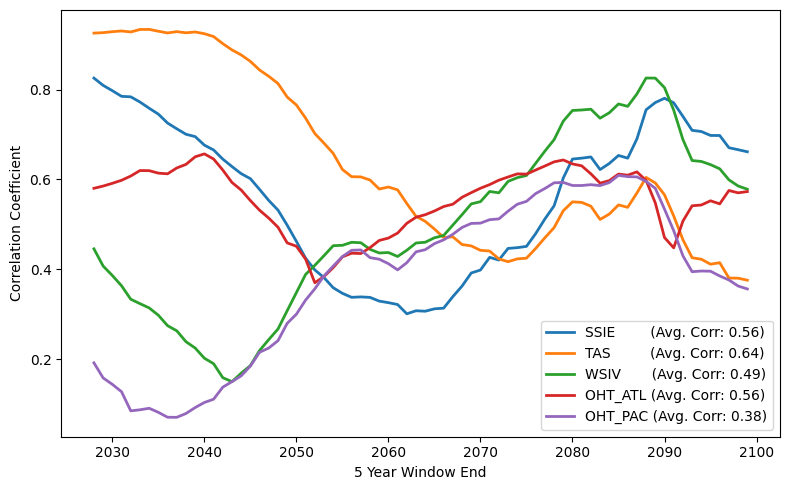

In [63]:
fig, ax = plt.subplots(figsize=(8, 5))

plot_corr_coeff(ec_outputs["ssie"]["results"], ax,    f"SSIE        (Avg. Corr: {ec_outputs["ssie"]["results"]["r"].mean():.2f})")
plot_corr_coeff(ec_outputs["tas"]["results"], ax,     f"TAS         (Avg. Corr: {ec_outputs["tas"]["results"]["r"].mean():.2f})")
plot_corr_coeff(ec_outputs["wsiv"]["results"], ax,    f"WSIV       (Avg. Corr: {ec_outputs["wsiv"]["results"]["r"].mean():.2f})")
plot_corr_coeff(ec_outputs["oht_atl"]["results"], ax, f"OHT_ATL (Avg. Corr: {ec_outputs["oht_atl"]["results"]["r"].mean():.2f})")
plot_corr_coeff(ec_outputs["oht_pac"]["results"], ax, f"OHT_PAC (Avg. Corr: {ec_outputs["oht_pac"]["results"]["r"].mean():.2f})")

plt.legend()
plt.tight_layout()
plt.show()

In [64]:
x_var = "tas"
y_var = "ssie"

ec_res = ec_outputs[x_var]["results"]

Text(0.02, 0.98, 'c)')

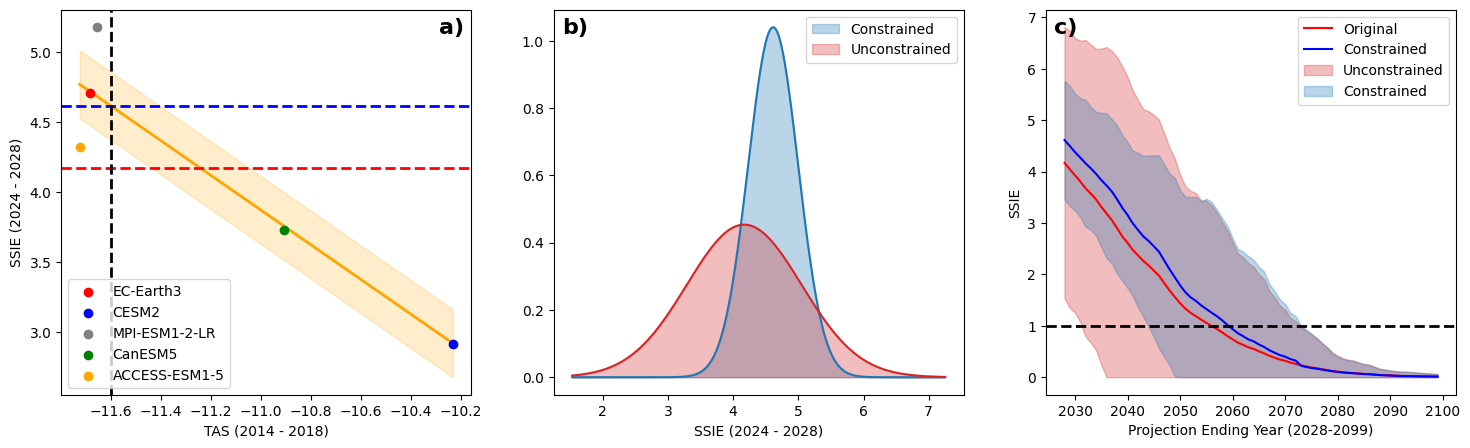

In [65]:
proj_end = 2028
row = ec_res[ec_res["proj_end"] == proj_end].reset_index(drop=True).loc[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

window_regression_plot(axes[0], x_var, y_var, row.to_dict())
window_prob_density(axes[1], row, y_var)
plot_con_v_uncon_series(axes[2], ec_res, y_var, clip=True, ify=True)

axes[0].text(0.92, 0.98, "a)", transform=axes[0].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[2].text(0.02, 0.98, "c)", transform=axes[2].transAxes, 
             fontsize=16, fontweight='bold', va='top')


In [66]:
get_uncertainity_reduction(row)

np.float64(0.5639689866389509)

In [67]:
get_constrained_diff(row)

np.float64(-0.09623429132666018)

In [48]:
ssie_ensemble_c_df, ssie_ensemble_uc_df = get_ensemble_dfs(ec_res)

#### TAS Target Variable

In [49]:
tas_ec_res = joblib.load(f"./icefreearcticml/outputs/emergent_constraints_tas_tas_linear.joblib")["results"]

x_var = "tas"
y_var = "tas"

Text(0.02, 0.98, 'c)')

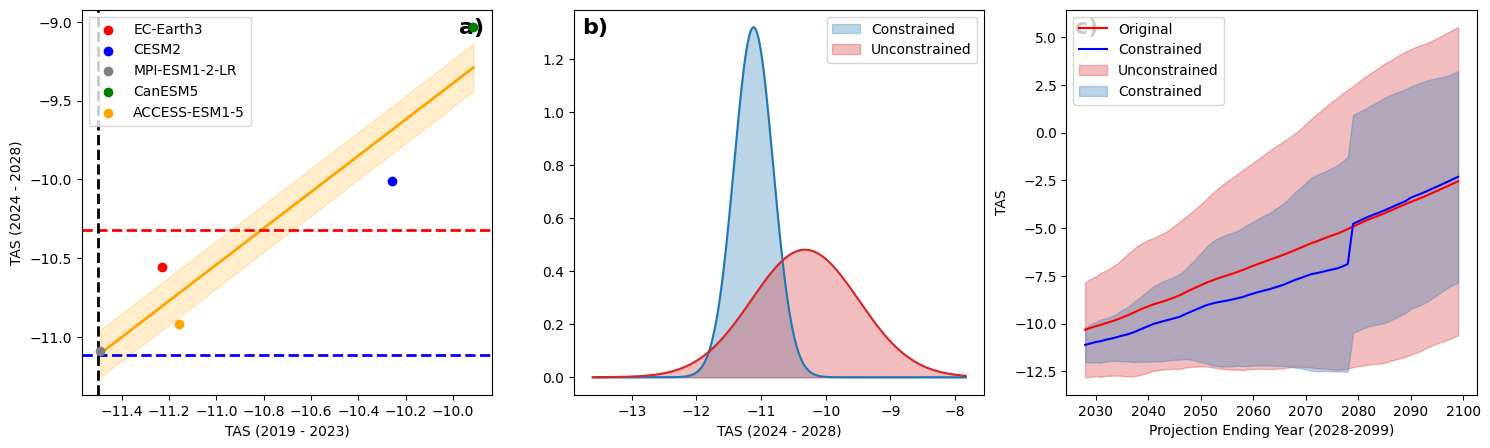

In [50]:
proj_end = 2028
row = tas_ec_res[tas_ec_res["proj_end"] == proj_end].reset_index(drop=True).loc[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

window_regression_plot(axes[0], x_var, y_var, row.to_dict())
window_prob_density(axes[1], row, y_var)
plot_con_v_uncon_series(axes[2], tas_ec_res, y_var, clip=False, ify=False)

axes[0].text(0.92, 0.98, "a)", transform=axes[0].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[2].text(0.02, 0.98, "c)", transform=axes[2].transAxes, 
             fontsize=16, fontweight='bold', va='top')

In [51]:
tas_ensemble_c_df, tas_ensemble_uc_df = get_ensemble_dfs(tas_ec_res, clip=False)

#### WSIV Target Variable

In [52]:
wsiv_ec_res = joblib.load(f"./icefreearcticml/outputs/emergent_constraints_wsiv_wsiv_linear.joblib")["results"]

x_var = "wsiv"
y_var = "wsiv"

Text(0.02, 0.98, 'c)')

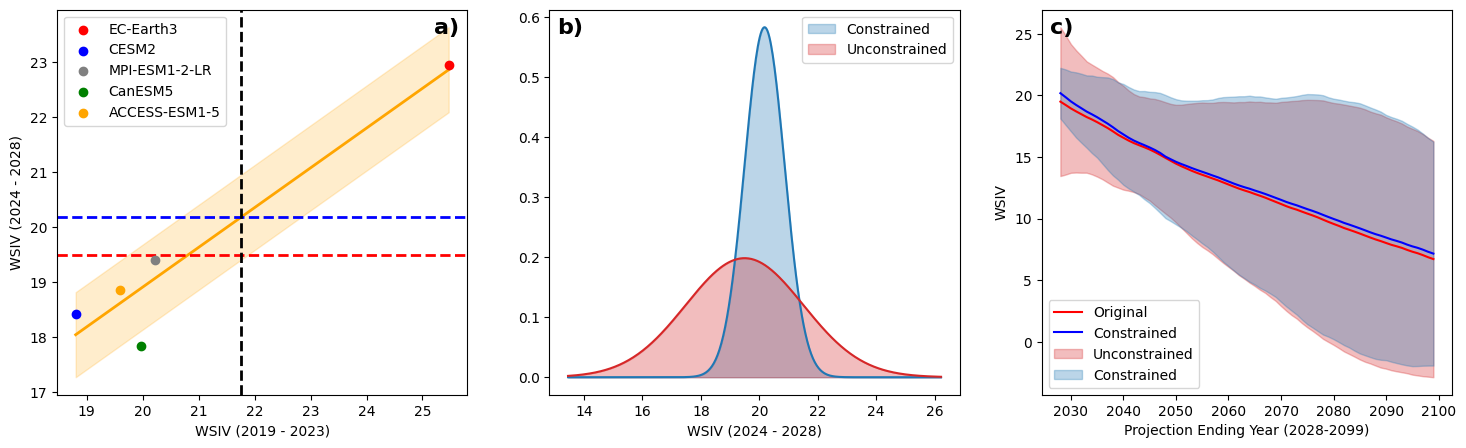

In [53]:
proj_end = 2028
row = wsiv_ec_res[wsiv_ec_res["proj_end"] == proj_end].reset_index(drop=True).loc[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

window_regression_plot(axes[0], x_var, y_var, row.to_dict())
window_prob_density(axes[1], row, y_var)
plot_con_v_uncon_series(axes[2], wsiv_ec_res, y_var, clip=False, ify=False)

axes[0].text(0.92, 0.98, "a)", transform=axes[0].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[2].text(0.02, 0.98, "c)", transform=axes[2].transAxes, 
             fontsize=16, fontweight='bold', va='top')

In [56]:
wsiv_ensemble_c_df, wsiv_ensemble_uc_df = get_ensemble_dfs(wsiv_ec_res, clip=False)

#### OHT_Atl Target Variable

In [54]:
oht_atl_ec_res = joblib.load(f"./icefreearcticml/outputs/emergent_constraints_oht_atl_oht_atl_linear.joblib")["results"]

x_var = "oht_atl"
y_var = "oht_atl"

Text(0.02, 0.98, 'c)')

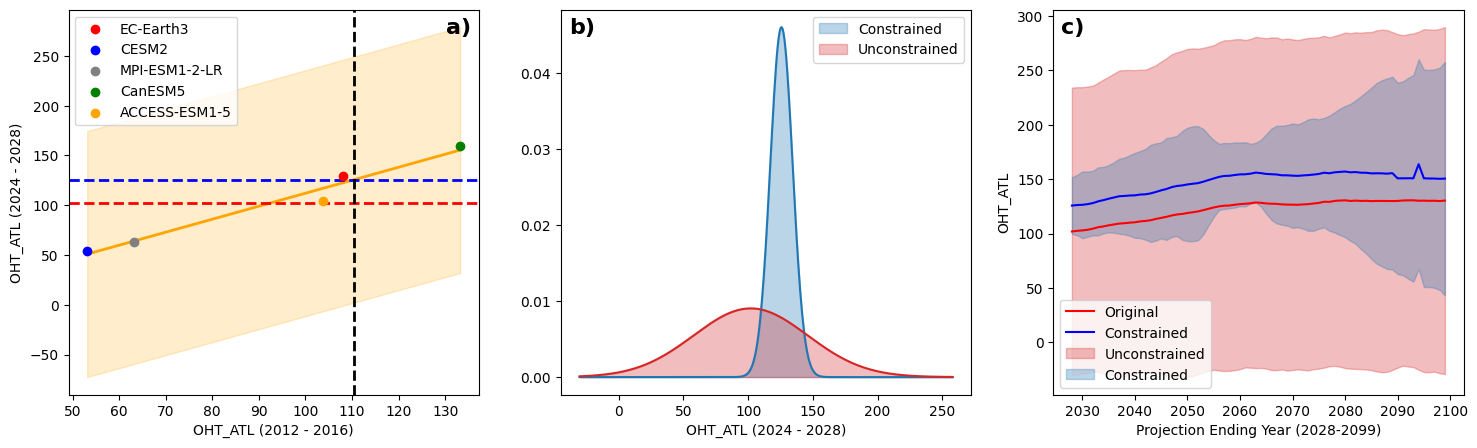

In [55]:
proj_end = 2028
row = oht_atl_ec_res[oht_atl_ec_res["proj_end"] == proj_end].reset_index(drop=True).loc[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

window_regression_plot(axes[0], x_var, y_var, row.to_dict())
window_prob_density(axes[1], row, y_var)
plot_con_v_uncon_series(axes[2], oht_atl_ec_res, y_var, clip=False, ify=False)

axes[0].text(0.92, 0.98, "a)", transform=axes[0].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[2].text(0.02, 0.98, "c)", transform=axes[2].transAxes, 
             fontsize=16, fontweight='bold', va='top')

In [57]:
oht_atl_ensemble_c_df, oht_atl_ensemble_uc_df = get_ensemble_dfs(oht_atl_ec_res, clip=False)

#### OHT_PAC Target Variable

In [58]:
oht_pac_ec_res = joblib.load(f"./icefreearcticml/outputs/emergent_constraints_oht_pac_oht_pac_linear.joblib")["results"]

x_var = "oht_pac"
y_var = "oht_pac"

Text(0.02, 0.98, 'c)')

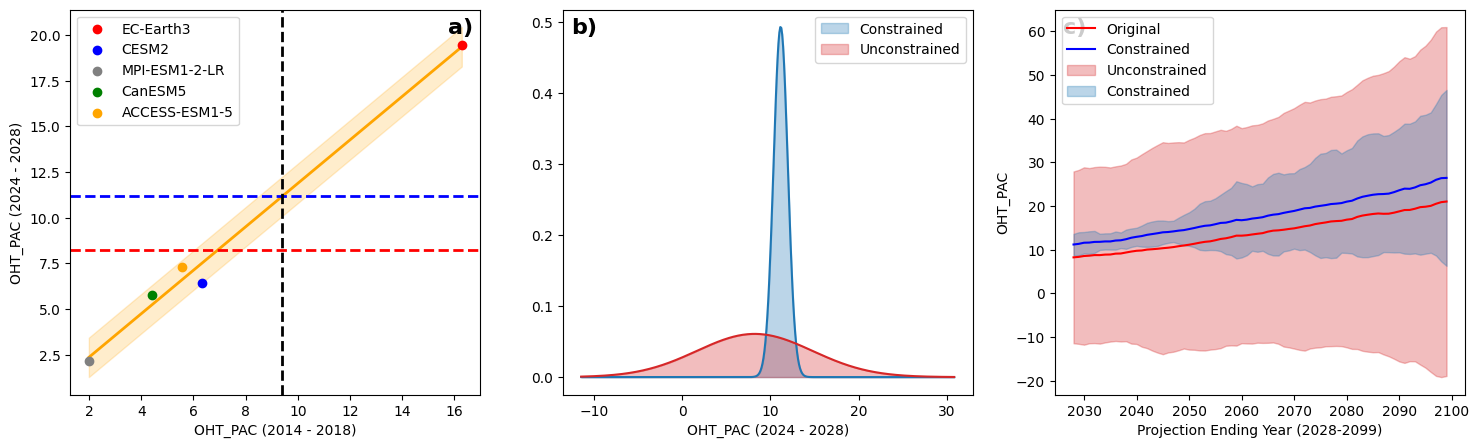

In [59]:
proj_end = 2028
row = oht_pac_ec_res[oht_pac_ec_res["proj_end"] == proj_end].reset_index(drop=True).loc[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

window_regression_plot(axes[0], x_var, y_var, row.to_dict())
window_prob_density(axes[1], row, y_var)
plot_con_v_uncon_series(axes[2], oht_pac_ec_res, y_var, clip=False, ify=False)

axes[0].text(0.92, 0.98, "a)", transform=axes[0].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
             fontsize=16, fontweight='bold', va='top')
axes[2].text(0.02, 0.98, "c)", transform=axes[2].transAxes, 
             fontsize=16, fontweight='bold', va='top')

In [60]:
oht_pac_ensemble_c_df, oht_pac_ensemble_uc_df = get_ensemble_dfs(oht_pac_ec_res, clip=False)

#### Emergent Constraint Liang-Kleeman and Ice Free Year Distribution

In [61]:
dt = 1
n_iter = 1000
liang_start = "2028-01-01"
liang_end = "2060-01-01"
x_liang = ["wsiv", "tas", "oht_atl", "oht_pac"]
y_liang = "ssie"

liang_config = LiangConfig(
    liang_start, liang_end, x_liang, y_liang, dt, n_iter,
)


In [62]:
VAR_YLABELS_SHORT = {
    "ssie": "SSIE",
    "wsie": "WSIE",
    "tas": "TAS",
    "wsiv": "WSIV",
    "oht_atl": "$OHT_{ATL}$",
    "oht_pac": "$OHT_{PAC}$",
}

In [63]:
model_name = "EmergConst"

ec_model_data = {
    "tas": {model_name: tas_ensemble_c_df},
    "wsiv": {model_name: wsiv_ensemble_c_df},
    "oht_atl": {model_name: oht_atl_ensemble_c_df},
    "oht_pac": {model_name: oht_pac_ensemble_c_df},
    "ssie": {model_name: ssie_ensemble_c_df},
}

/home/benjamin/icefreearcticml/icefreearcticml/liangindex/function_liang_nvar.py:84: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  a1k = np.dot(np.linalg.inv(C),dC[:,i]) # compute a1k coefficients based on matrix-vector product (see beginning of page 4 in Liang (2014))


Text(0.02, 0.98, 'b)')

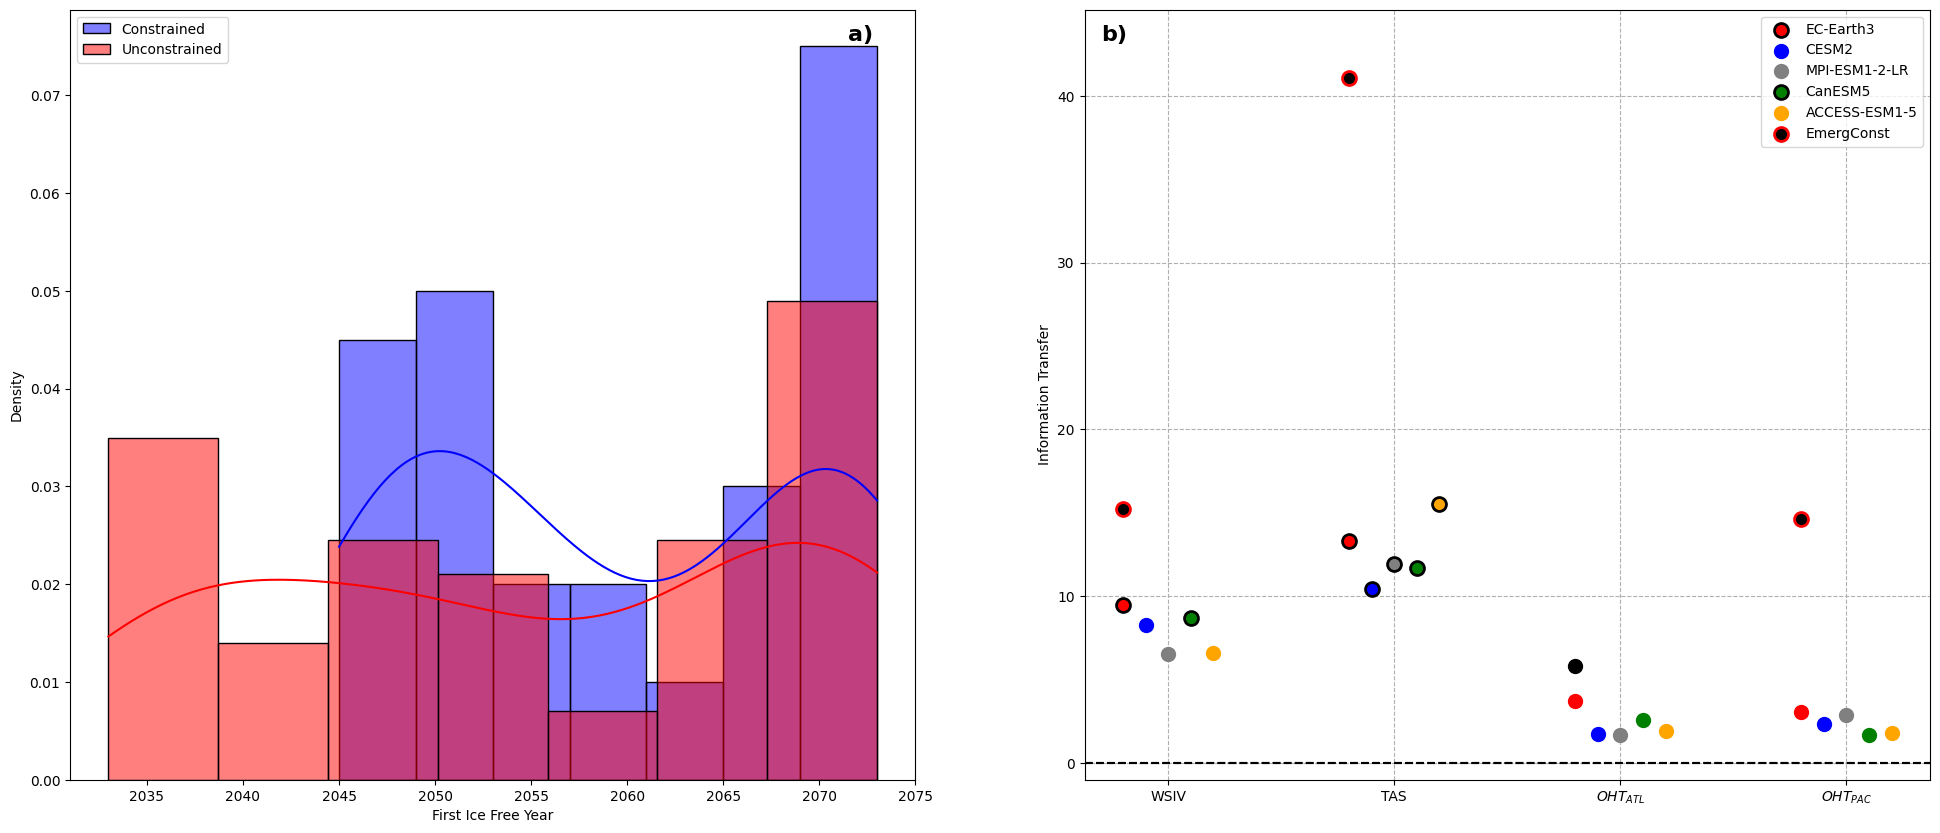

In [64]:
dt = 1
n_iter = 1000
liang_start = "2028-01-01"
liang_end = "2060-01-01"
x_liang = ["wsiv", "tas", "oht_atl", "oht_pac"]
y_liang = "ssie"

liang_config = LiangConfig(
    liang_start, liang_end, x_liang, y_liang, dt, n_iter,
)

original_liang_res = calculate_all_liang_flows(model_data, liang_config, MODEL_NAMES)
ec_liang_res = calculate_all_liang_flows(ec_model_data, liang_config, [model_name])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,10))

icefree_year_dist_c = calculate_first_icefree_year(ssie_ensemble_c_df)
icefree_year_dist_uc = calculate_first_icefree_year(ssie_ensemble_uc_df)

sns.histplot(icefree_year_dist_c.values, kde=True, stat='density', color="blue", label="Constrained", ax=axes[0])
sns.histplot(icefree_year_dist_uc.values, kde=True, stat='density', color="red", label="Unconstrained", ax=axes[0])

plot_liang_tau_avgs(axes[1], original_liang_res, liang_config.x_liang)
plot_liang_tau_avgs(axes[1], ec_liang_res, liang_config.x_liang, [model_name])

axes[0].legend()
axes[0].set_xlabel("First Ice Free Year")
axes[0].text(0.92, 0.98, "a)", transform=axes[0].transAxes, 
             fontsize=16, fontweight='bold', va='top')

axes[1].legend()
axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
             fontsize=16, fontweight='bold', va='top')

### Statistical Bias Correction

In [26]:
from icefreearcticml.icefreearcticml.constants import MODEL_COLOURS
from icefreearcticml.icefreearcticml.utils.utils import (
    calculate_ensemble_max,
    calculate_ensemble_mean,
    calculate_ensemble_min,
)

In [ ]:
bias_corrections = joblib.load("./icefreearcticml/outputs/bias_corrections.joblib")
bias_correction_scores = joblib.load("./icefreearcticml/outputs/bias_correction_scores.joblib")
bias_correction_mse = read_csv("./icefreearcticml/outputs/bias_correction_mse.csv")

In [18]:
variables = list(bias_corrections["linear_scaling"].keys())

In [106]:
bias_correction_mse

Unnamed: 0  linear_scaling  variance_scaling  quantile_mapping
0       ssie        0.823293          1.349334          0.636493
1        tas        0.837333          2.545513          0.500727
2       wsiv        8.108882         18.553845          2.984541
3    oht_atl      366.473045        423.181387        181.153653
4    oht_pac       14.281265         19.531225         13.313585

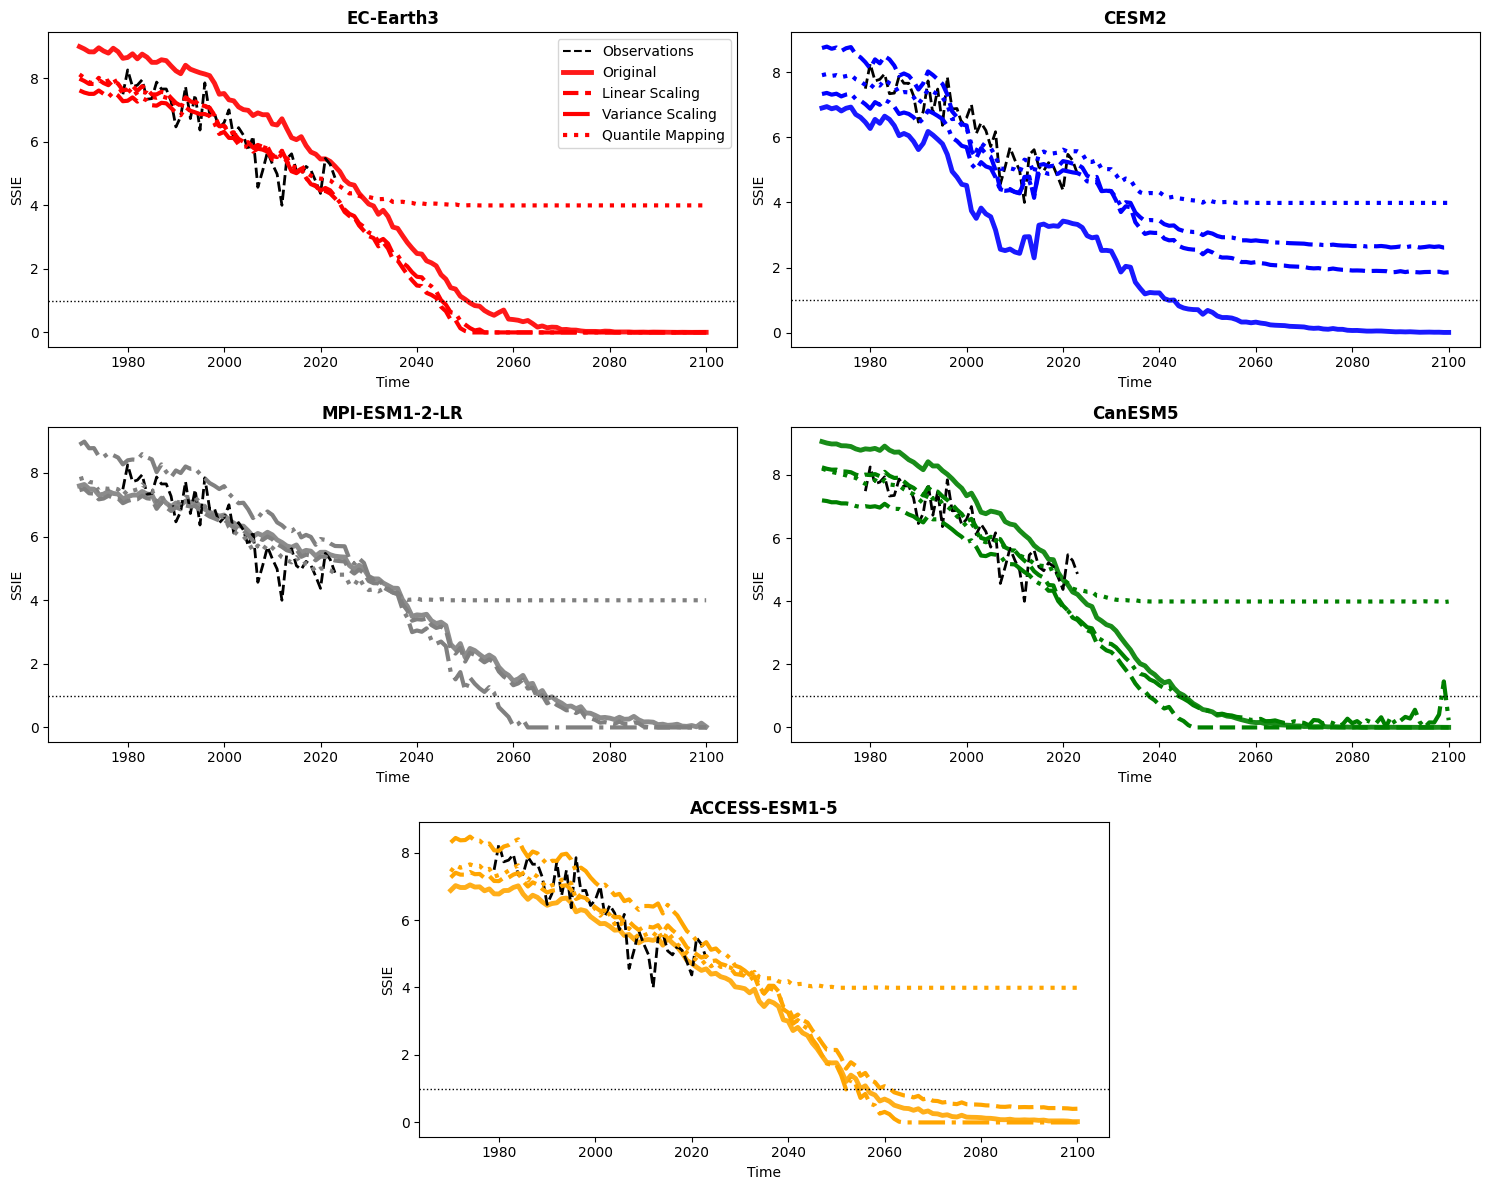

In [ ]:
BIAS_METHOD_STYLES = {
    'linear_scaling': {'linestyle': '--', 'linewidth': 3.0},
    'variance_scaling': {'linestyle': '-.', 'linewidth': 3.0},
    'quantile_mapping': {'linestyle': ':', 'linewidth': 3.0}
}
ORIGINAL_STYLE = {'linestyle': '-', 'linewidth': 3.5, 'alpha': 0.9}
SHADING_ALPHA = 0.1


def plot_series(ax: plt.Axes, data: DataFrame, style: str, colour: str, label: str, clip: bool = False) -> None:
    mean = calculate_ensemble_mean(data)
    if clip:
        mean = mean.clip(0)
    # max = calculate_ensemble_max(data)
    # min = calculate_ensemble_min(data)
    ax.plot(mean.index, mean, 
            color=colour, **style, label=label)
    # ax.fill_between(mean.index, min, max, 
    #                 color=colour, alpha=SHADING_ALPHA)
    
def create_ensemble_bias_correction_figures(bias_corrections, original_data_dict, variable, clip: bool = False, ify: bool = False):
    models = list(MODEL_COLOURS.keys())
    bias_methods = list(bias_corrections.keys())
    
    fig = plt.figure(figsize=(15, 12))
    fig.set_constrained_layout(False)
    gs = gridspec.GridSpec(3, 2, figure=fig)
    axes = [fig.add_subplot(gs[i]) for i in range(4)]
    ax5 = fig.add_subplot(gs[2, :])
    axes.append(ax5)
    
    for idx, ax in enumerate(axes):
        model = models[idx]
        colour = MODEL_COLOURS[model]

        plot_series(ax, original_data_dict[variable][model],
                    ORIGINAL_STYLE, colour, "Original", clip)
        obs = original_data_dict[variable]["Observations"]
        ax.plot(obs.index, obs, color="black", ls="--", label="Observations", lw=2)
        for method in bias_methods:
            plot_series(ax, bias_corrections[method][variable][model],
                        BIAS_METHOD_STYLES[method], colour,
                        method.replace('_', ' ').title(), clip)
        ax.set_title(f'{model}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel(variable.upper())
        if ify:
            ax.axhline(y=1, ls=":", color="black", lw=1)
        if idx == 0:
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color='black', ls="--", label='Observations'),
                Line2D([0], [0], color='red', **ORIGINAL_STYLE, label='Original'),
                *[Line2D([0], [0], color='red', **BIAS_METHOD_STYLES[method],
                        label=method.replace('_', ' ').title())
                  for method in bias_methods]
            ]
            ax.legend(handles=legend_elements, loc='upper right')

    fig.tight_layout()
    fig.canvas.draw()

    ref_pos = axes[0].get_position()
    pos5 = ax5.get_position()
    new_width = ref_pos.width
    x0 = pos5.x0 + (pos5.width - new_width) / 2
    ax5.set_position([x0, pos5.y0, new_width, pos5.height])

    fig.canvas.draw_idle()
    return fig

_ = create_ensemble_bias_correction_figures(bias_corrections, model_data, "ssie", clip=True, ify=True)


In [ ]:
_ = create_ensemble_bias_correction_figures(bias_corrections, model_data, "oht_pac", clip=False, ify=False)

In [40]:
BM_AKPHA = {
    "linear_scaling": 0.1,
    "variance_scaling": 0.5
}

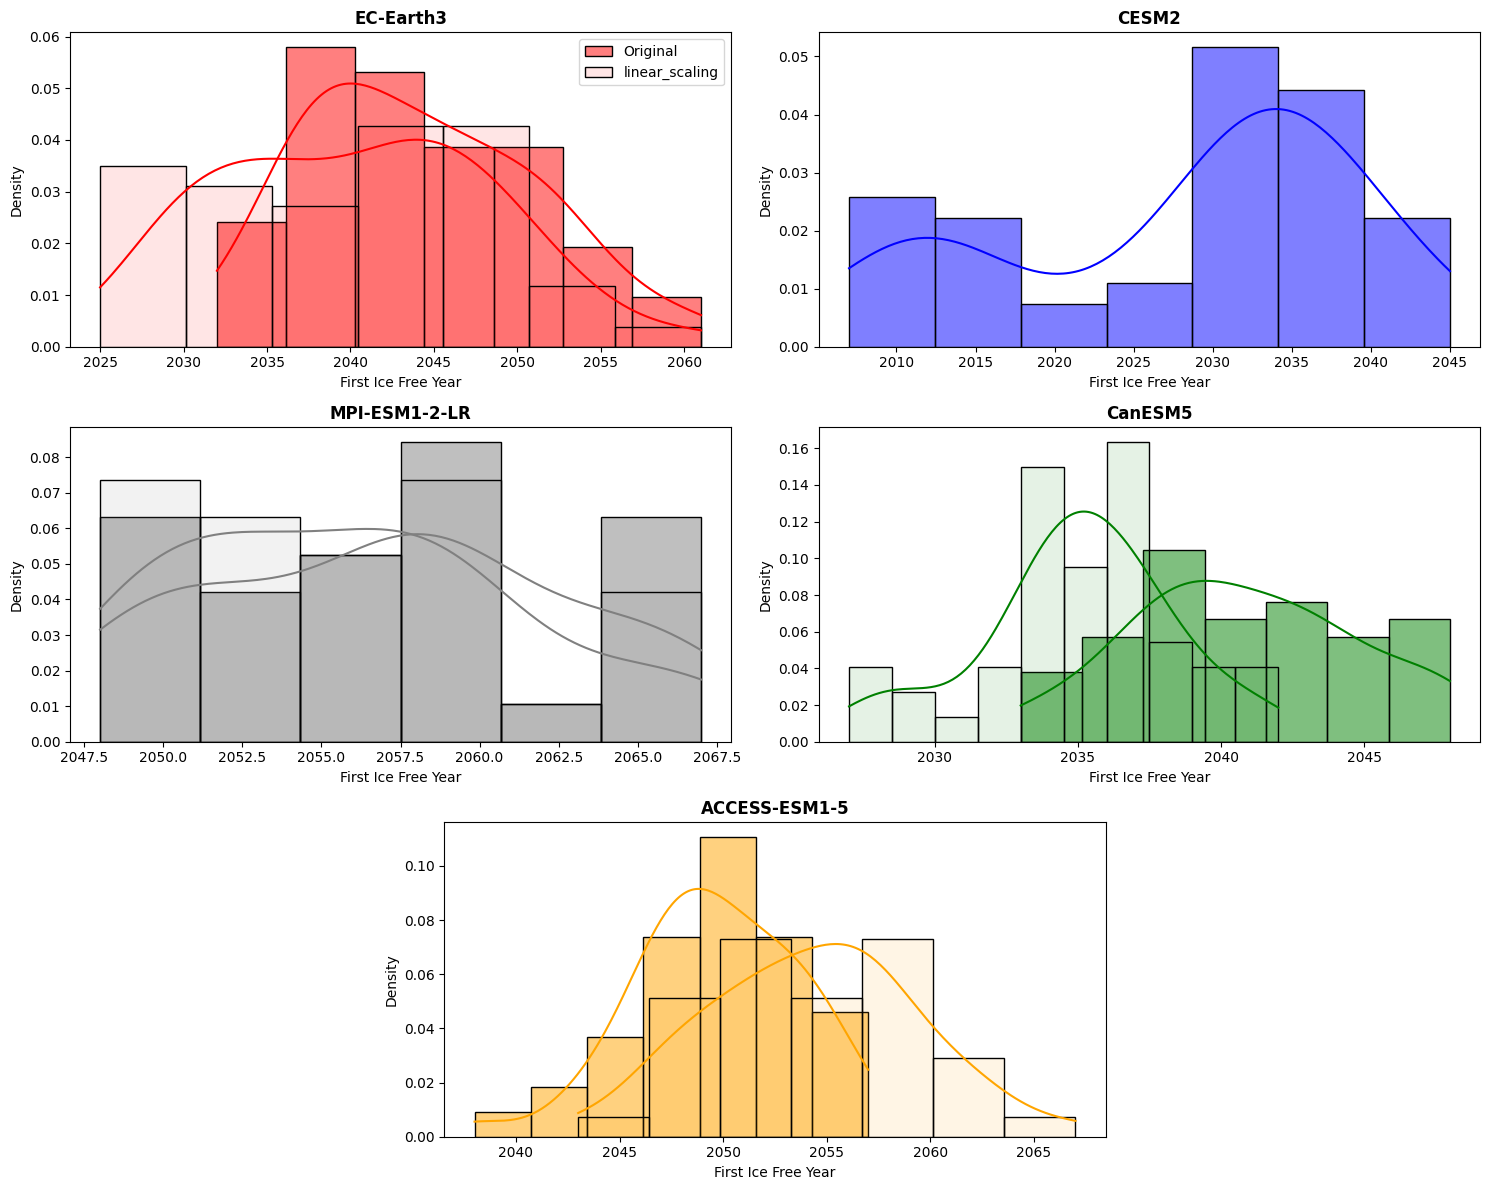

In [46]:
models = list(MODEL_COLOURS.keys())
bias_methods = list(bias_corrections.keys())

fig = plt.figure(figsize=(15, 12))
fig.set_constrained_layout(False)
gs = gridspec.GridSpec(3, 2, figure=fig)
axes = [fig.add_subplot(gs[i]) for i in range(4)]
ax5 = fig.add_subplot(gs[2, :])
axes.append(ax5)


for idx, ax in enumerate(axes):
    model = models[idx]
    colour = MODEL_COLOURS[model]

    original_ify = ice_free_year_ds.sel(ensemble=ice_free_year_ds.ensemble.str.contains(model))["ice_free_years"].dt.year
    sns.histplot(original_ify.values, kde=True, stat='density', color=colour, label="Original", ax=ax)

    for method in bias_methods:
        if method == "linear_scaling":
            method_ify = calculate_first_icefree_year(bias_corrections[method]["ssie"][model])
            method_ify = method_ify.dt.year.replace(1970, np.nan).dropna()
            if not method_ify.empty:
                sns.histplot(method_ify.values, kde=True, stat='density', color=colour, label=method, ax=ax, alpha=BM_AKPHA[method])

    ax.set_title(model, fontsize=12, fontweight='bold')
    ax.set_xlabel('First Ice Free Year')


    if idx == 0:
        ax.legend()

fig.tight_layout()
fig.canvas.draw()

ref_pos = axes[0].get_position()
pos5 = ax5.get_position()
new_width = ref_pos.width
x0 = pos5.x0 + (pos5.width - new_width) / 2
ax5.set_position([x0, pos5.y0, new_width, pos5.height])

fig.canvas.draw_idle()

In [64]:
dt = 1
n_iter = 1000
liang_start = "1979-01-01"
liang_end = "2060-01-01"
x_liang = ["wsiv", "tas", "oht_atl", "oht_pac"]
y_liang = "ssie"

liang_config = LiangConfig(
    liang_start, liang_end, x_liang, y_liang, dt, n_iter,
)

bias_corrected_model_data = bias_corrections["linear_scaling"]

original_liang_res = calculate_all_liang_flows(model_data, liang_config, MODEL_NAMES)
ls_bc_liang_res = calculate_all_liang_flows(bias_corrected_model_data, liang_config, MODEL_NAMES)

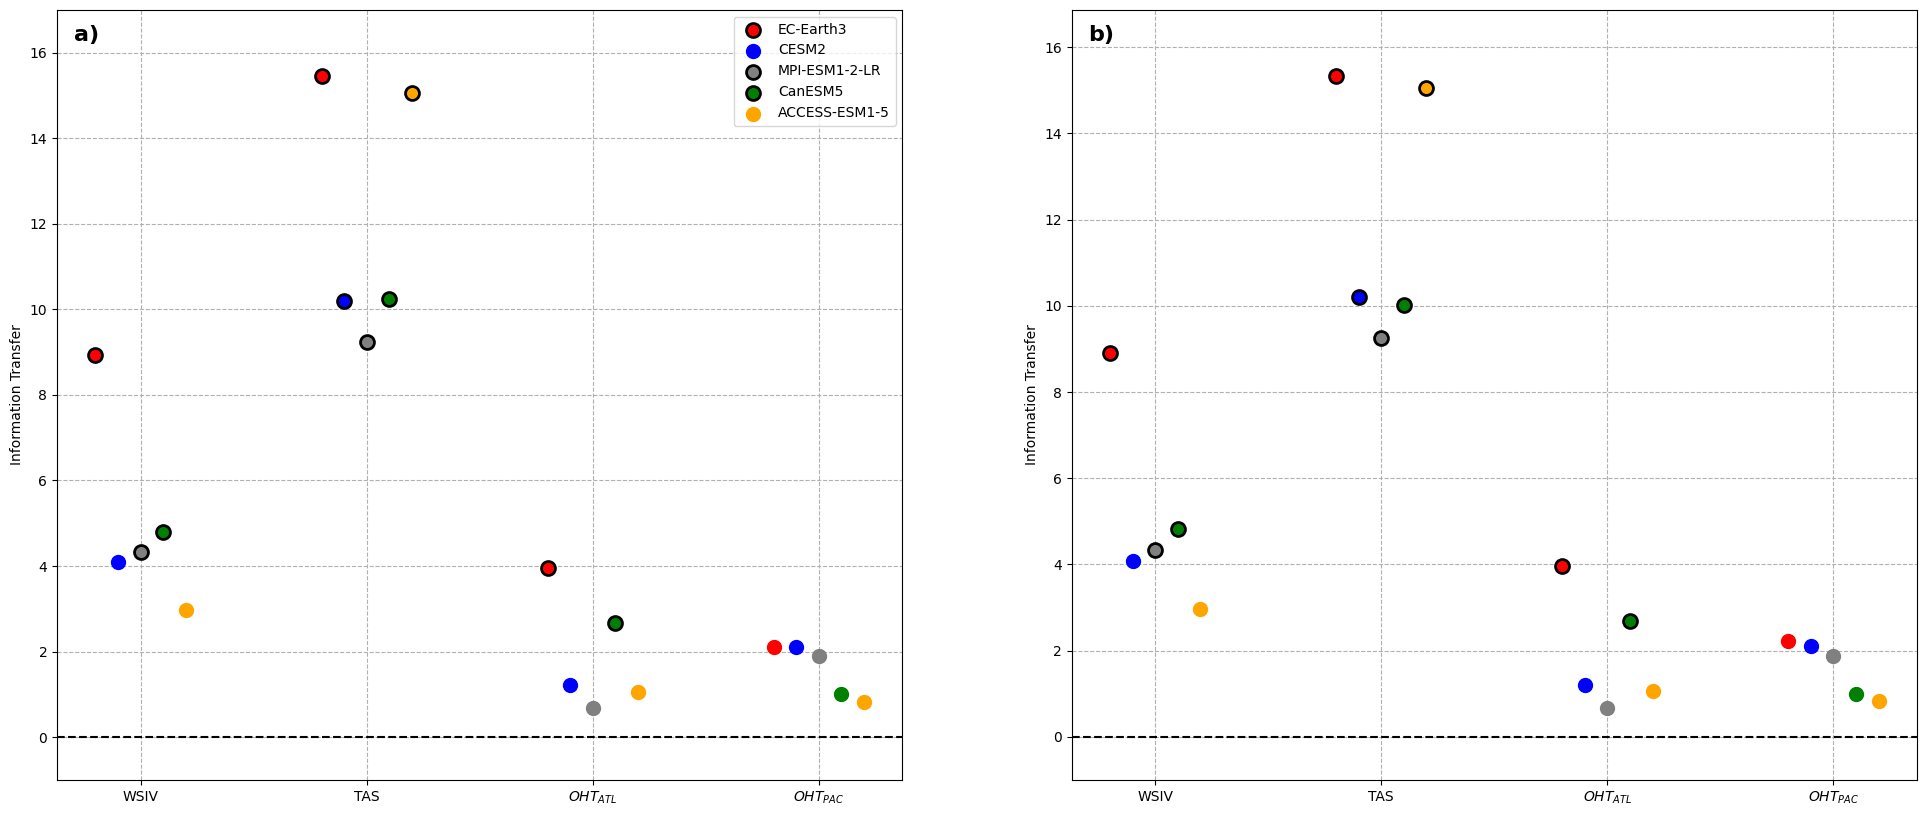

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,10))


plot_liang_tau_avgs(axes[0], original_liang_res, liang_config.x_liang)
plot_liang_tau_avgs(axes[1], ls_bc_liang_res, liang_config.x_liang, MODEL_NAMES)

axes[0].text(0.02, 0.98, "a)", transform=axes[0].transAxes, 
             fontsize=16, fontweight='bold', va='top')

axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
             fontsize=16, fontweight='bold', va='top')

axes[0].legend()

### Machine Learning Bias Correction

In [67]:
bs_ml_uni_res = joblib.load("./icefreearcticml/outputs/bias_correction_ml_univariate.joblib")

In [149]:
def plot_bc_ml_res(
        ax: plt.Axes,
        var: str,
        var_data: DataFrame,
        y_pred: DataFrame,
        obs_series: DataFrame,
        y_emul_df: DataFrame,
        title: str,
    ) -> None:
    for i, col in enumerate(var_data.columns):
        label = "Original CMPI6 Data" if i == 0 else None
        ax.plot(var_data[col], color="blue", label=label)
    for j, col in enumerate(y_pred.columns):
        label = "Predicted" if j == 0 else None
        ax.plot(y_pred[col], color="red", label=label)
    ax.plot(y_emul_df, color="red")
    ax.plot(obs_series, "k--", lw=3, label="Observations")
    ax.set_ylabel(var.upper())
    ax.set_title(title.replace("_", " ").title())
    ax.legend()

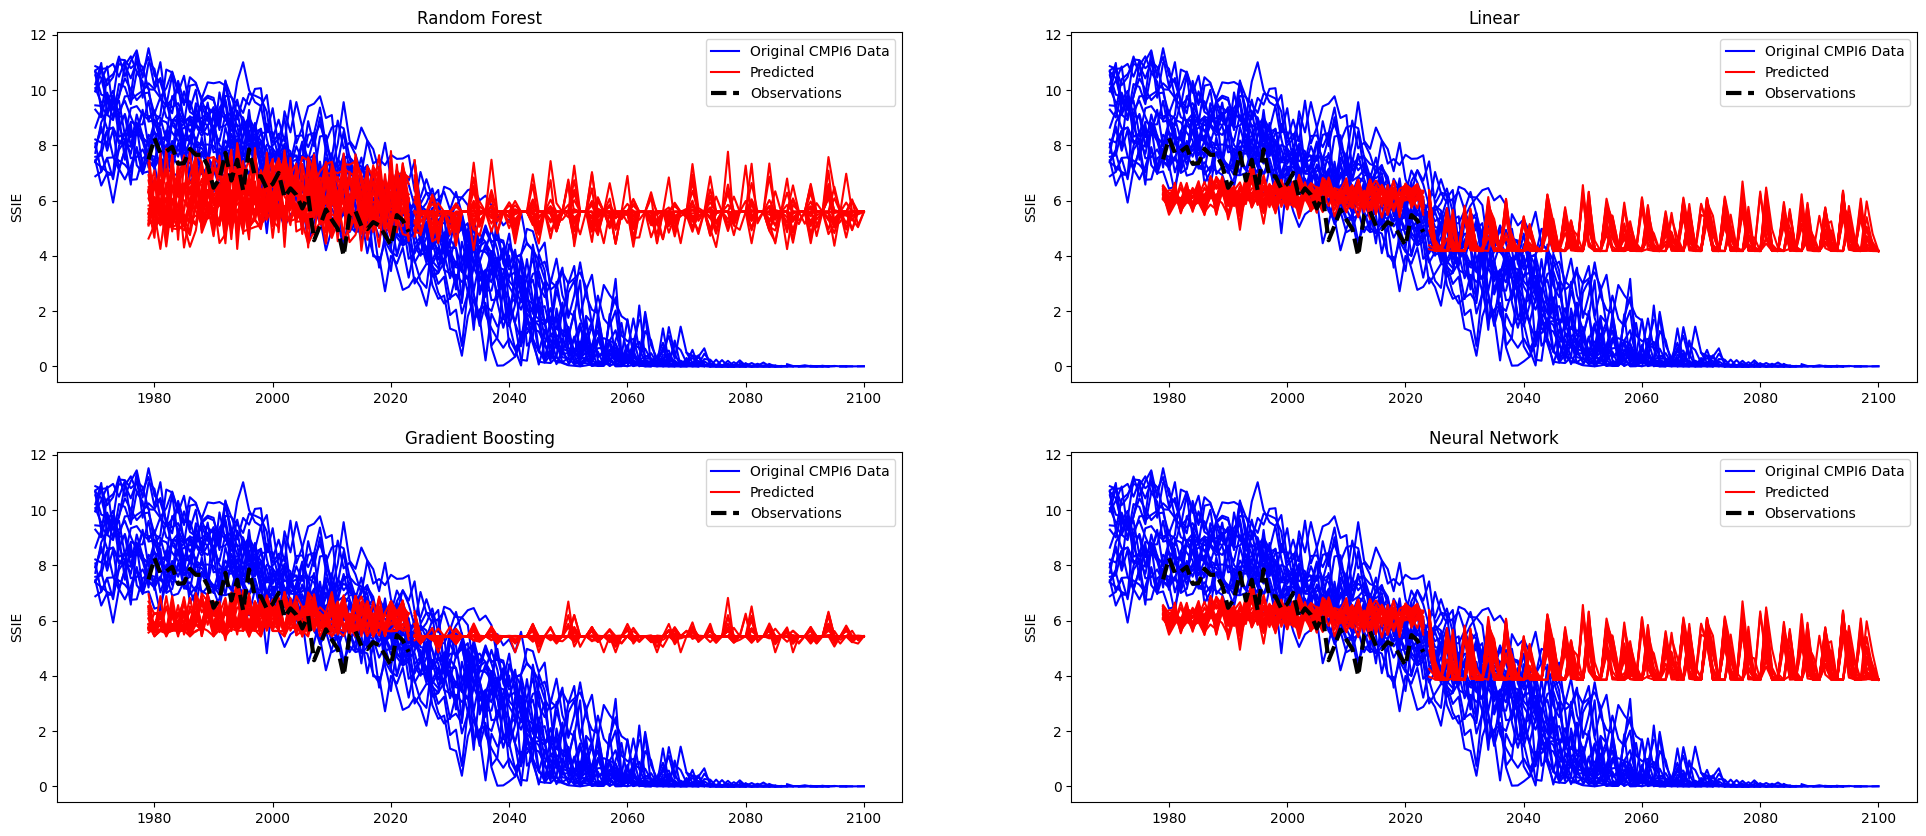

In [155]:
METHODS = ["random_forest", "linear", "gradient_boosting", "neural_network"]

var = "ssie"
model_name = "all"

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,10))
axes = axes.flatten()

obs_series = model_data[var]["Observations"]

for i, ax in enumerate(axes):
    method = METHODS[i]
    res = bs_ml_uni_res[f"{var}_{model_name}_{method}"]
    test_members = res["y_pred_df"].columns

    var_data = model_data[var][model_name]
    test_members = var_data.columns[:len(test_members)]
    emul_data = var_data.loc[var_data.index[var_data.index >= "2024-01-01"]][test_members].fillna(0)
    x_emul_data = emul_data.melt()["value"].values.reshape(-1,1)

    model = res["model"]
    emul_pred = model.predict(x_emul_data)
    y_emul_df = DataFrame(emul_pred.reshape(len(emul_data.index), len(test_members)), index=emul_data.index)
    
    plot_bc_ml_res(ax, var, var_data[test_members], res["y_pred_df"], obs_series, y_emul_df, method)


In [157]:
bs_ml_multi_res = joblib.load("./icefreearcticml/outputs/bias_correction_ml_multivariate.joblib")

In [163]:
bs_ml_multi_res["EC-Earth3_linear"]["data_res"].keys()

dict_keys(['x_train', 'x_val', 'x_test', 'y_train', 'y_val', 'y_test', 'train_members', 'val_members', 'test_members', 'obs_series'])

In [167]:
bs_ml_multi_res["EC-Earth3_linear"]["data_res"]

{'x_train': array([[  7.403679  , -13.18941059,  39.49151172,  95.63947329,
           7.96555713],
        [  7.288861  , -13.23768496,  40.22126172,  90.37478624,
           6.4205687 ],
        [  6.240445  , -11.87814202,  38.99171094, 106.9720052 ,
          13.97385479],
        ...,
        [  5.117278  , -11.13612365,  21.12800781, 133.74693603,
          11.5829937 ],
        [  5.471317  , -11.28410914,  21.96016992, 120.33449113,
          19.30692552],
        [  6.1590205 , -12.63980252,  24.92621875, 132.64733236,
          15.83755322]], shape=(1800, 5)),
 'x_val': array([[  9.656397  , -16.61719333,  54.28336719,  68.8899151 ,
           7.12877813],
        [ 10.450566  , -16.9599947 ,  53.471375  ,  53.06796221,
           4.04701775],
        [ 10.580512  , -17.30964184,  54.56367187,  51.3713277 ,
           7.01203903],
        ...,
        [  6.383886  , -11.50530945,  27.76905859, 145.07311121,
           8.40053462],
        [  5.85206   , -10.53858368,  29.7879

IndexError: list index out of range

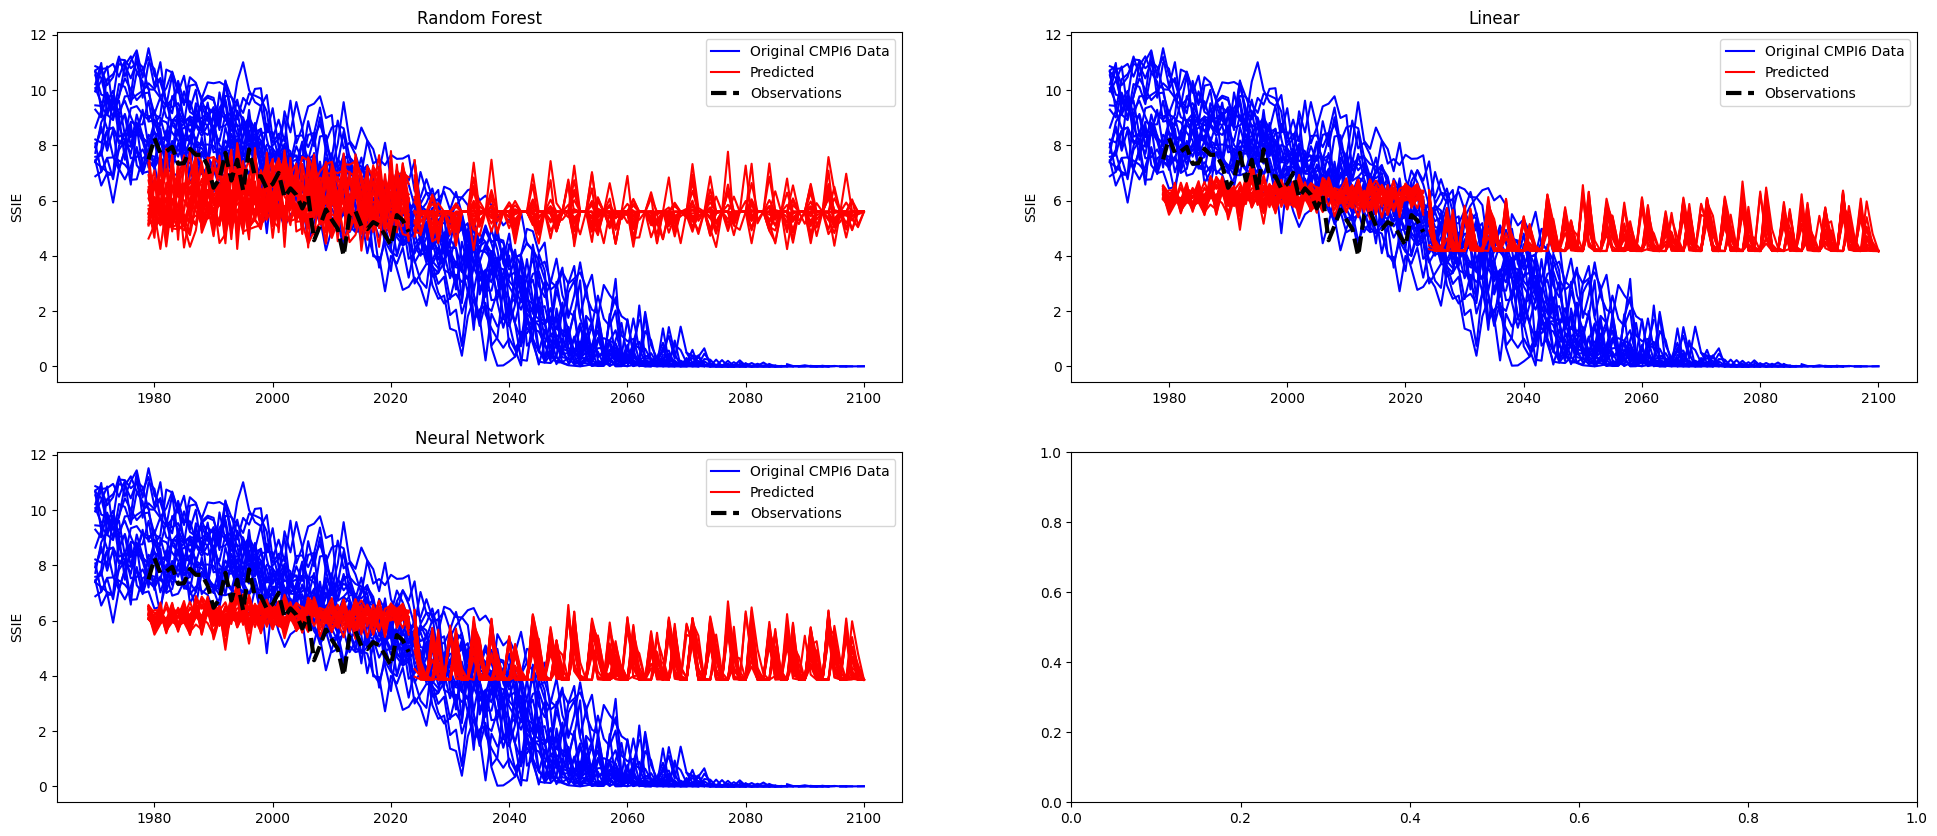

In [160]:
METHODS = ["random_forest", "linear", "neural_network", "chained_rf"]

var = "ssie"
model_name = "all"

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,10))
axes = axes.flatten()


for i, ax in enumerate(axes):
    method = METHODS[i]
    res = bs_ml_multi_res[f"{model_name}_{method}"]
    test_members = res["y_pred_df"].columns

    var_data = model_data[var][model_name]
    test_members = var_data.columns[:len(test_members)]
    emul_data = var_data.loc[var_data.index[var_data.index >= "2024-01-01"]][test_members].fillna(0)
    x_emul_data = emul_data.melt()["value"].values.reshape(-1,1)

    model = res["model"]
    emul_pred = model.predict(x_emul_data)
    y_emul_df = DataFrame(emul_pred.reshape(len(emul_data.index), len(test_members)), index=emul_data.index)
    
    plot_bc_ml_res(ax, var, var_data[test_members], res["y_pred_df"], obs_series, y_emul_df, method)


### TaylorTransformer

In [3]:
def prepare_x_emul(vars: list, model_data: dict, data_res: dict, start_date: str = "1970-01-01") -> torch.tensor:
    x_test = []

    for var in vars:
        var_data = model_data[var][model_name]
        model_series = var_data.loc[var_data.index > start_date].fillna(0)

        x_data = model_series.values.T
        n = x_data.shape[0]
        x_test.append(x_data[:, :, np.newaxis])

    m = data_res["y_test"].shape[0]
    x_data = torch.tensor(np.concatenate(x_test, axis=2), dtype=torch.float32)[:m, :, :,]

    return x_data, model_series.index

def plot_tt(ax: plt.Axes, x_index: np.ndarray, predictions: np.ndarray, x_data: np.ndarray, obs_series: np.ndarray, n_shift: int = 10) -> None:
    x = x_data.squeeze().T
    _ = ax.plot(x_index, x.mean(axis=1), color="red", label="Original")

    ax.fill_between(x_index, x.min(axis=1).values, x.max(axis=1).values, color='red', alpha=0.3)

    p = predictions.squeeze().T
    _ = ax.plot(x_index[n_shift:], p.mean(axis=1), color="blue", label="TaylorTransformer")
    ax.fill_between(x_index[n_shift:], p.min(axis=1), p.max(axis=1), color='blue', alpha=0.3)
    ax.plot(obs_series, "k--", lw=2, label="Observations")


In [4]:
taylor_transform_univar_res = joblib.load("./icefreearcticml/outputs/taylortransformer_single_var_bc_results.pkl")
taylor_transform_multi_res = joblib.load("./icefreearcticml/outputs/taylortransformer_multi_var_bc_results.pkl")

In [104]:
taylor_transform_univar_res.keys()

dict_keys(['ssie_EC-Earth3', 'ssie_CESM2', 'ssie_MPI-ESM1-2-LR', 'ssie_CanESM5', 'ssie_ACCESS-ESM1-5', 'ssie_all', 'tas_EC-Earth3', 'tas_CESM2', 'tas_MPI-ESM1-2-LR', 'tas_CanESM5', 'tas_ACCESS-ESM1-5', 'tas_all', 'wsiv_EC-Earth3', 'wsiv_CESM2', 'wsiv_MPI-ESM1-2-LR', 'wsiv_CanESM5', 'wsiv_ACCESS-ESM1-5', 'wsiv_all', 'oht_atl_EC-Earth3', 'oht_atl_CESM2', 'oht_atl_MPI-ESM1-2-LR', 'oht_atl_CanESM5', 'oht_atl_ACCESS-ESM1-5', 'oht_atl_all', 'oht_pac_EC-Earth3', 'oht_pac_CESM2', 'oht_pac_MPI-ESM1-2-LR', 'oht_pac_CanESM5', 'oht_pac_ACCESS-ESM1-5', 'oht_pac_all'])

In [5]:
MODEL_KWARGS = {
    'num_heads': 1,
    'projection_shape_for_head': 8,
    'output_shape': 1,
    'rate': 0.1,
    'num_layers': 4,
    'enc_dim': 32,
    'permutation_repeats': 1,
}

In [7]:
var = "ssie"
model_name = "all"

res = taylor_transform_univar_res[f'{var}_{model_name}']

In [8]:
data_res = prepare_data(model_data, [var], model_name, 0.8, 0.1)

In [10]:
data_res.keys()

dict_keys(['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test', 'train_idx', 'val_idx', 'test_idx'])

In [14]:
indices = [data_res['train_idx'], data_res['val_idx'], data_res['test_idx']]

In [15]:
model = TaylorFormerPipeline(**MODEL_KWARGS)
model.load_state_dict(res["model"])

<All keys matched successfully>

In [16]:
tt_model_data = {}

In [17]:
x_data, x_index = prepare_x_emul([var], model_data, data_res)

full_n = len(x_index)
total_years = 120
n_shift = full_n - total_years
prediction_chunk = 45 - n_shift

predictions, uncertainties = generate_emulation(model, x_data, data_res["y_test"], total_years=total_years, prediction_chunk=prediction_chunk)
obs_series = model_data[var]["Observations"]

In [39]:
tt_model_data["ssie"] = {"TaylorTransformer": DataFrame(predictions.squeeze().T, index=x_index[n_shift:])}

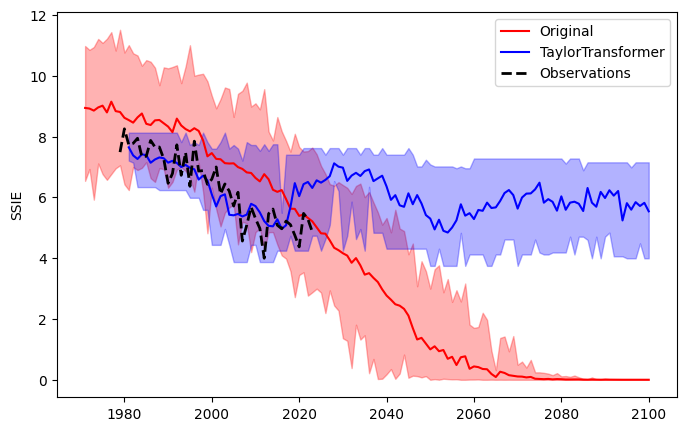

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
plot_tt(ax, x_index, predictions, x_data, obs_series, n_shift=n_shift)
ax.set_ylabel("SSIE")
ax.legend()

In [20]:
x_vars = ["tas", "wsiv", "oht_atl", "oht_pac"]

In [21]:
data_res = prepare_data(model_data, x_vars, model_name, 0.8, 0.1, indices=indices)
x_data, x_index = prepare_x_emul(x_vars, model_data, data_res)

full_n = len(x_index)
total_years = 120
n_shift = full_n - total_years
prediction_chunk = 45 - n_shift

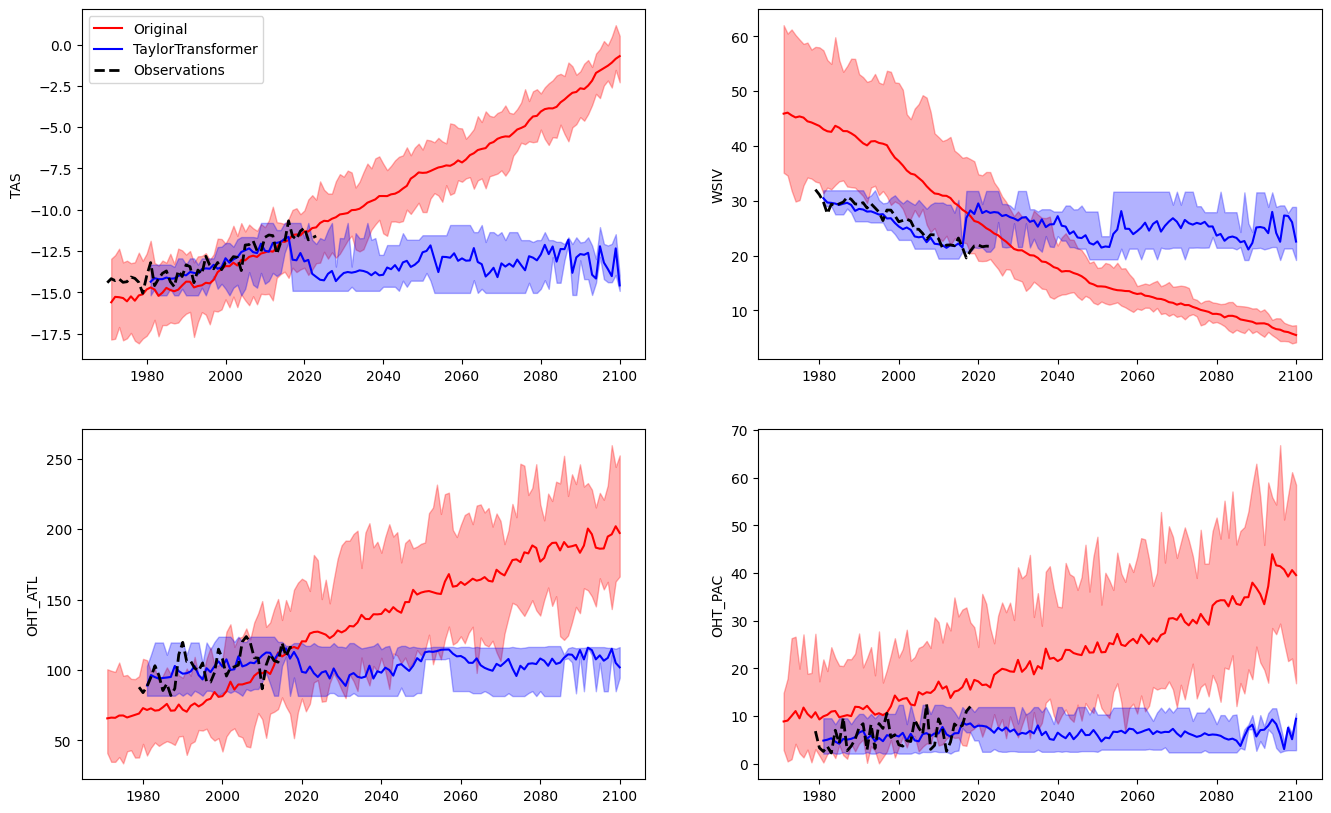

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
axes = axes.flatten()

for var in x_vars:
    idx = x_vars.index(var)
    ax = axes[idx]

    predictions, uncertainties = generate_emulation(
        model, x_data[:, :, idx:idx+1], data_res["y_test"][:, :, idx:idx+1],
        total_years=total_years, prediction_chunk=prediction_chunk,
    )
    tt_model_data[var] = {"TaylorTransformer": DataFrame(predictions.squeeze().T, index=x_index[n_shift:])}
    obs_series = model_data[var]["Observations"]

    plot_tt(ax, x_index, predictions, x_data[:, :, idx:idx+1], obs_series, n_shift=n_shift)
    ax.set_ylabel(var.upper())
    if idx == 0:
        ax.legend()

In [46]:
dt = 1
n_iter = 1000
liang_start = "1980-01-01"
liang_end = "2060-01-01"
x_liang = ["wsiv", "tas", "oht_atl", "oht_pac"]
y_liang = "ssie"

liang_config = LiangConfig(
    liang_start, liang_end, x_liang, y_liang, dt, n_iter,
)
model_data_filtered = {
    var: {"Original": model_dict["all"][model_dict["all"].columns[indices[0]]].loc[x_index].fillna(0)} for var, model_dict in model_data.items()
}

model_name = "TaylorTransformer"
original_filtered_liang_res = calculate_all_liang_flows(model_data_filtered, liang_config, ["Original"])
pred_liang_res = calculate_all_liang_flows(tt_model_data, liang_config, [model_name])

LinAlgError: Matrix is singular to machine precision.

In [44]:
tt_model_data["ssie"]["TaylorTransformer"]

0          1          2          3          4          5   \
1981-01-01   6.715197   3.560254   6.903035   3.560254   2.454870   3.517023   
1982-01-01   6.715197   9.539706   3.221151   2.454870   3.517023   2.127631   
1983-01-01   5.014025   3.560254   2.454870   9.539706   2.633399   5.014025   
1984-01-01   8.278912   8.278912   5.014025   6.903035   3.517023   6.715197   
1985-01-01   2.633399   2.773015   6.903035   7.474371   2.127631   5.014025   
...               ...        ...        ...        ...        ...        ...   
2096-01-01   8.185987   8.185987   8.185987   8.185987   3.593971   8.185987   
2097-01-01   4.637024   2.833683   2.833683   2.833683   2.833683   2.833683   
2098-01-01   7.970582   7.970582   7.970582   7.970582   2.844150   7.970582   
2099-01-01   4.762691   4.762691   4.637024   4.762691   4.637024   4.762691   
2100-01-01  10.617662  10.617662  10.617662  10.617662  10.617662  10.617662   

                   6          7          8         9   ...         13  \
1981-01-01   4.153417   3.517023   6.903035  3.560254  ...   4.153417   
1982-01-01   3.560254   2.633399   2.127631  3.560254  ...   2.127631   
1983-01-01   6.903035   6.715197   3.221151  9.539706  ...   3.560254   
1984-01-01   6.715197   2.454870   3.560254  3.560254  ...   2.127631   
1985-01-01   2.454870   3.517023   2.633399  4.153417  ...   3.221151   
...               ...        ...        ...       ...  ...        ...   
2096-01-01   8.185987   3.593971   8.185987  3.593971  ...   8.185987   
2097-01-01   2.833683   4.637024   2.833683  2.833683  ...   2.833683   
2098-01-01   7.970582   7.970582   7.970582  7.970582  ...   7.970582   
2099-01-01   4.762691   4.762691   4.762691  4.762691  ...   4.762691   
2100-01-01  10.617662  10.617662  10.617662  7.970582  ...  10.617662   

                   14        15        16        17        18        19  \
1981-01-01   3.517023  2.454870  2.127631  3.560254  9.539706  9.539706   
1982-01-01   5.014025  6.715197  2.633399  2.127631  6.715197  9.539706   
1983-01-01   6.715197  3.560254  4.153417  6.903035  6.715197  9.539706   
1984-01-01   8.278912  2.633399  3.560254  2.633399  2.454870  3.560254   
1985-01-01   5.014025  2.633399  6.903035  2.773015  2.127631  6.903035   
...               ...       ...       ...       ...       ...       ...   
2096-01-01   8.185987  4.637024  4.637024  4.637024  2.396014  4.637024   
2097-01-01   2.833683  2.833683  2.833683  2.833683  2.708016  2.833683   
2098-01-01   7.970582  7.808454  7.808454  7.808454  7.808454  7.808454   
2099-01-01   4.762691  6.338196  6.338196  6.338196  2.844150  6.338196   
2100-01-01  10.617662  8.185987  8.185987  2.844150  8.185987  8.185987   

                  20        21        22  
1981-01-01  3.560254  9.539706  6.903035  
1982-01-01  9.539706  9.539706  6.903035  
1983-01-01  7.474371  3.560254  3.517023  
1984-01-01  6.715197  2.633399  3.221151  
1985-01-01  2.127631  4.153417  9.539706  
...              ...       ...       ...  
2096-01-01  4.637024  4.637024  2.396014  
2097-01-01  2.833683  2.833683  2.833683  
2098-01-01  7.808454  7.808454  4.637024  
2099-01-01  6.338196  6.338196  6.338196  
2100-01-01  8.185987  8.185987  8.185987  

[120 rows x 23 columns]

In [ ]:
plot_liang_tau_avgs(axes[1], original_filtered_liang_res, liang_config.x_liang, ["Original"], replace_edge_col="red")

### TemporalFusionTransformer

In [68]:
out_files = [
    "warm_cold_small_bias_remove_outputs",
    "warm_cold_large_bias_remove_outputs",
    "warm_cold_half_split_model_outputs",
    "abs_small_bias_remove_outputs",
    "abs_large_bias_remove_outputs",
    "abs_half_split_model_outputs",
    "no_removaL_run",
]


In [69]:
def get_y_and_test_memebers(output: Output) -> tuple:
    test_members = output.train_config.test_members
    y = model_data["ssie"]["all"][test_members].fillna(0)
    return y, test_members

def plot_y_vs_pred(ax: plt.Axes, output: DataFrame, y: DataFrame) -> None:
    pred_kw = {
        "ls": "--"
    }
    legend_elements = []
    for model_name in MODEL_NAMES:
        colour = MODEL_COLOURS[model_name]
        ax.plot(y.filter(regex=model_name).mean(axis=1), color=colour)
        ax.plot(y.filter(regex=model_name).min(axis=1), color=colour)
        ax.plot(y.filter(regex=model_name).max(axis=1), color=colour)

        t = output.y_pred_simul.filter(regex=model_name).clip(0).mean(axis=1)
        ax.plot(t, color=colour, **pred_kw)
        ax.plot(output.y_pred_simul.filter(regex=model_name).clip(0).min(axis=1), color=colour, **pred_kw)
        ax.plot(output.y_pred_simul.filter(regex=model_name).clip(0).max(axis=1), color=colour, **pred_kw)

        if not t.empty:
            legend_elements.append(
                Line2D([0], [0], color=colour, label=f"{model_name} Predicted", **pred_kw),
            )
            legend_elements.append(
                Line2D([0], [0], color=colour, label=model_name),
            )

    ax.set_ylabel("SSIE")
    ax.legend(handles=legend_elements)

def prepare_liang_data(output: Output, model_name: str, test_members: list, vars: list) -> tuple:
    pred_index = output.y_pred_simul.index
    model_data_filtered = {
        var: {"Original": model_dict["all"][test_members].loc[pred_index]} for var, model_dict in model_data.items()
    }
    pred_model_data = {
        var: {model_name: model_data_filtered[var]["Original"]} for var in vars
    }
    pred_model_data["ssie"] = {}
    pred_model_data["ssie"][model_name] = output.y_pred_simul

    original_filtered_liang_res = calculate_all_liang_flows(model_data_filtered, liang_config, ["Original"])
    pred_liang_res = calculate_all_liang_flows(pred_model_data, liang_config, [model_name])
    return original_filtered_liang_res, pred_liang_res

def plot_densities_and_liang(
        icefree_year_dist_pred: Series,
        icefree_year_dist: Series,
        original_filtered_liang_res: dict,
        pred_liang_res: dict,
        model_name: str,
        liang_config: LiangConfig,
        model_colours: list,
        pred_first: bool = True,
        axes: plt.Axes | None = None,
        letter_i: int = 0,
    ) -> None:
    if axes is None:
        _, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,10))

    sns.histplot(icefree_year_dist_pred.values, kde=True, stat='density', color="blue", label=model_name, ax=axes[0])
    sns.histplot(icefree_year_dist.values, kde=True, stat='density', color="red", label="Original", ax=axes[0])
    
    if pred_first:
        plot_liang_tau_avgs(axes[1], pred_liang_res, liang_config.x_liang, [model_name], model_colours, replace_edge_col="blue")
        plot_liang_tau_avgs(axes[1], original_filtered_liang_res, liang_config.x_liang, ["Original"], model_colours, replace_edge_col="red")
    else:
        plot_liang_tau_avgs(axes[1], original_filtered_liang_res, liang_config.x_liang, ["Original"], model_colours, replace_edge_col="red")
        plot_liang_tau_avgs(axes[1], pred_liang_res, liang_config.x_liang, [model_name], model_colours, replace_edge_col="blue")

    axes[0].legend()
    axes[0].set_xlabel("First Ice Free Year")
    axes[0].text(0.02, 0.98, f"{chr(97 + letter_i)})", transform=axes[0].transAxes, 
                fontsize=16, fontweight='bold', va='top')

    axes[1].text(0.02, 0.98, f"{chr(97 + letter_i + 1)})", transform=axes[1].transAxes, 
                fontsize=16, fontweight='bold', va='top')
    axes[1].legend()

In [70]:
dt = 1
n_iter = 1000
liang_start = "1980-01-01"
liang_end = "2060-01-01"
x_liang = ["wsiv", "tas", "oht_atl", "oht_pac"]
y_liang = "ssie"

liang_config = LiangConfig(
    liang_start, liang_end, x_liang, y_liang, dt, n_iter,
)

#### Baseline

In [71]:
res = joblib.load(f"./icefreearcticml/outputs/{out_files[-1]}.pkl")

In [72]:
y, test_members = get_y_and_test_memebers(res)

In [73]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# plot_y_vs_pred(ax, res, y)

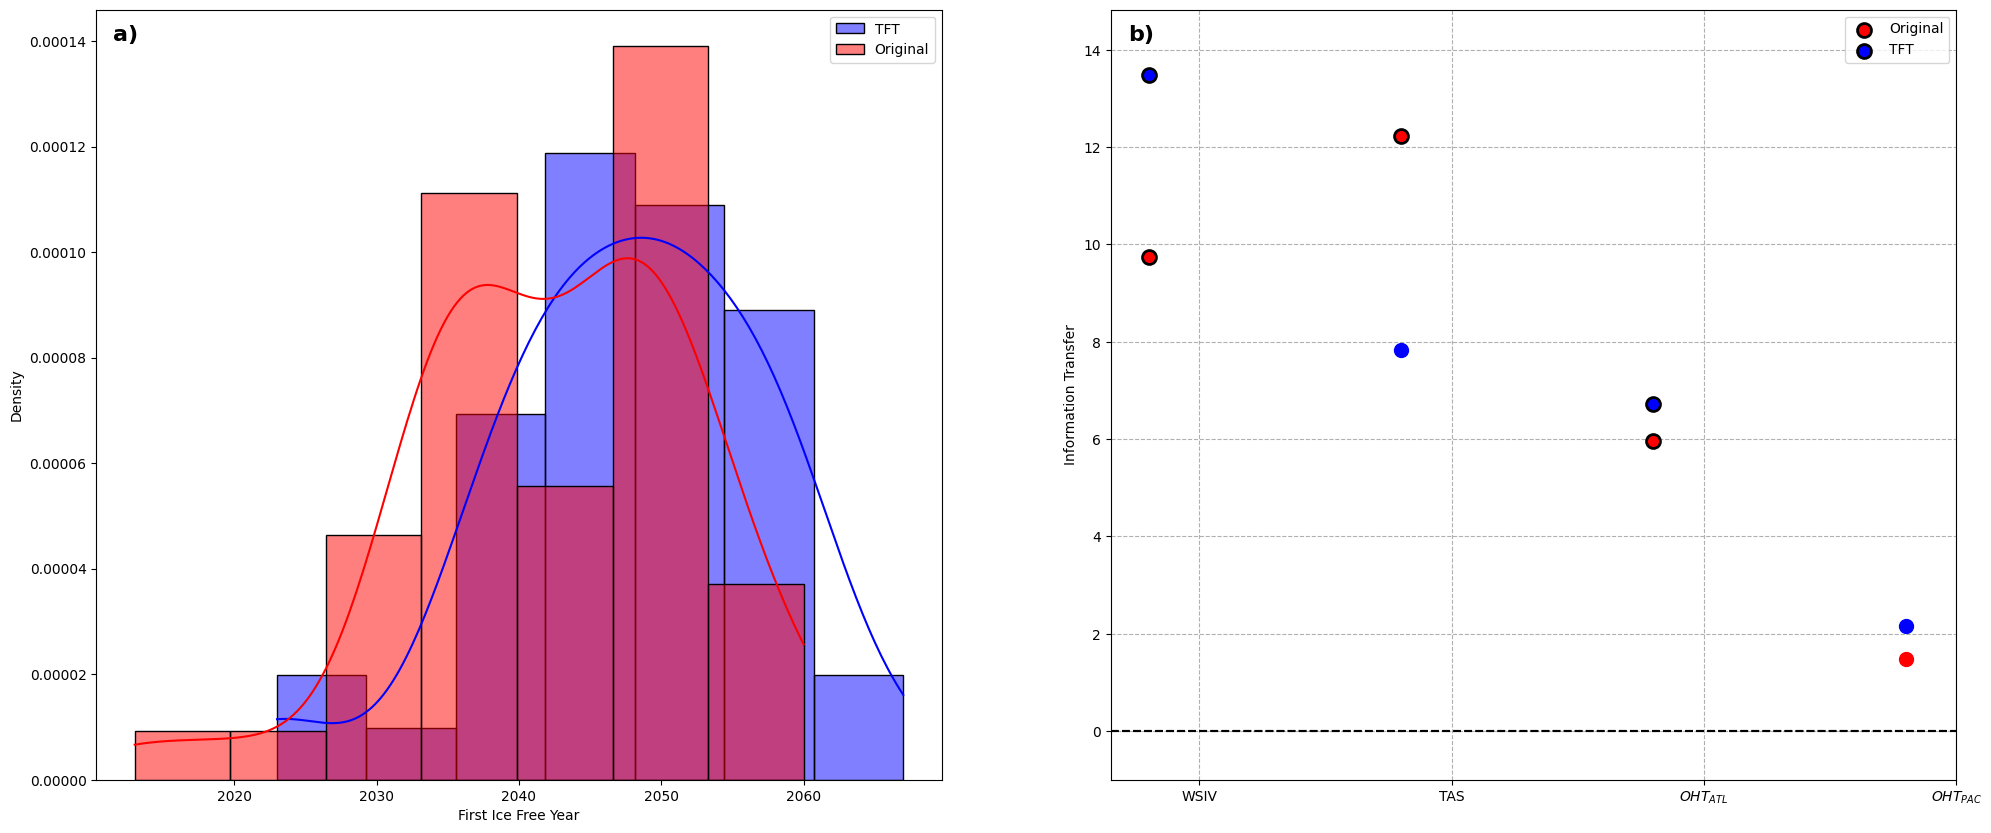

In [75]:
model_name = "TFT"
model_colours = {
    model_name: "blue",
    "Original": "red"
}

original_filtered_liang_res, pred_liang_res = prepare_liang_data(res, model_name, test_members, x_liang)

icefree_year_dist_pred = calculate_first_icefree_year(res.y_pred_simul)
icefree_year_dist = calculate_first_icefree_year(y)

plot_densities_and_liang(
    icefree_year_dist_pred, icefree_year_dist,
    original_filtered_liang_res, pred_liang_res, model_name,
    liang_config, model_colours, pred_first=False,
)

#### Filtering

In [9]:
res_abs = joblib.load(f"./icefreearcticml/outputs/abs_large_remove_outputs.joblib")
res_wc = joblib.load(f"./icefreearcticml/outputs/warm_cold_large_remove_outputs.joblib")

Absolute

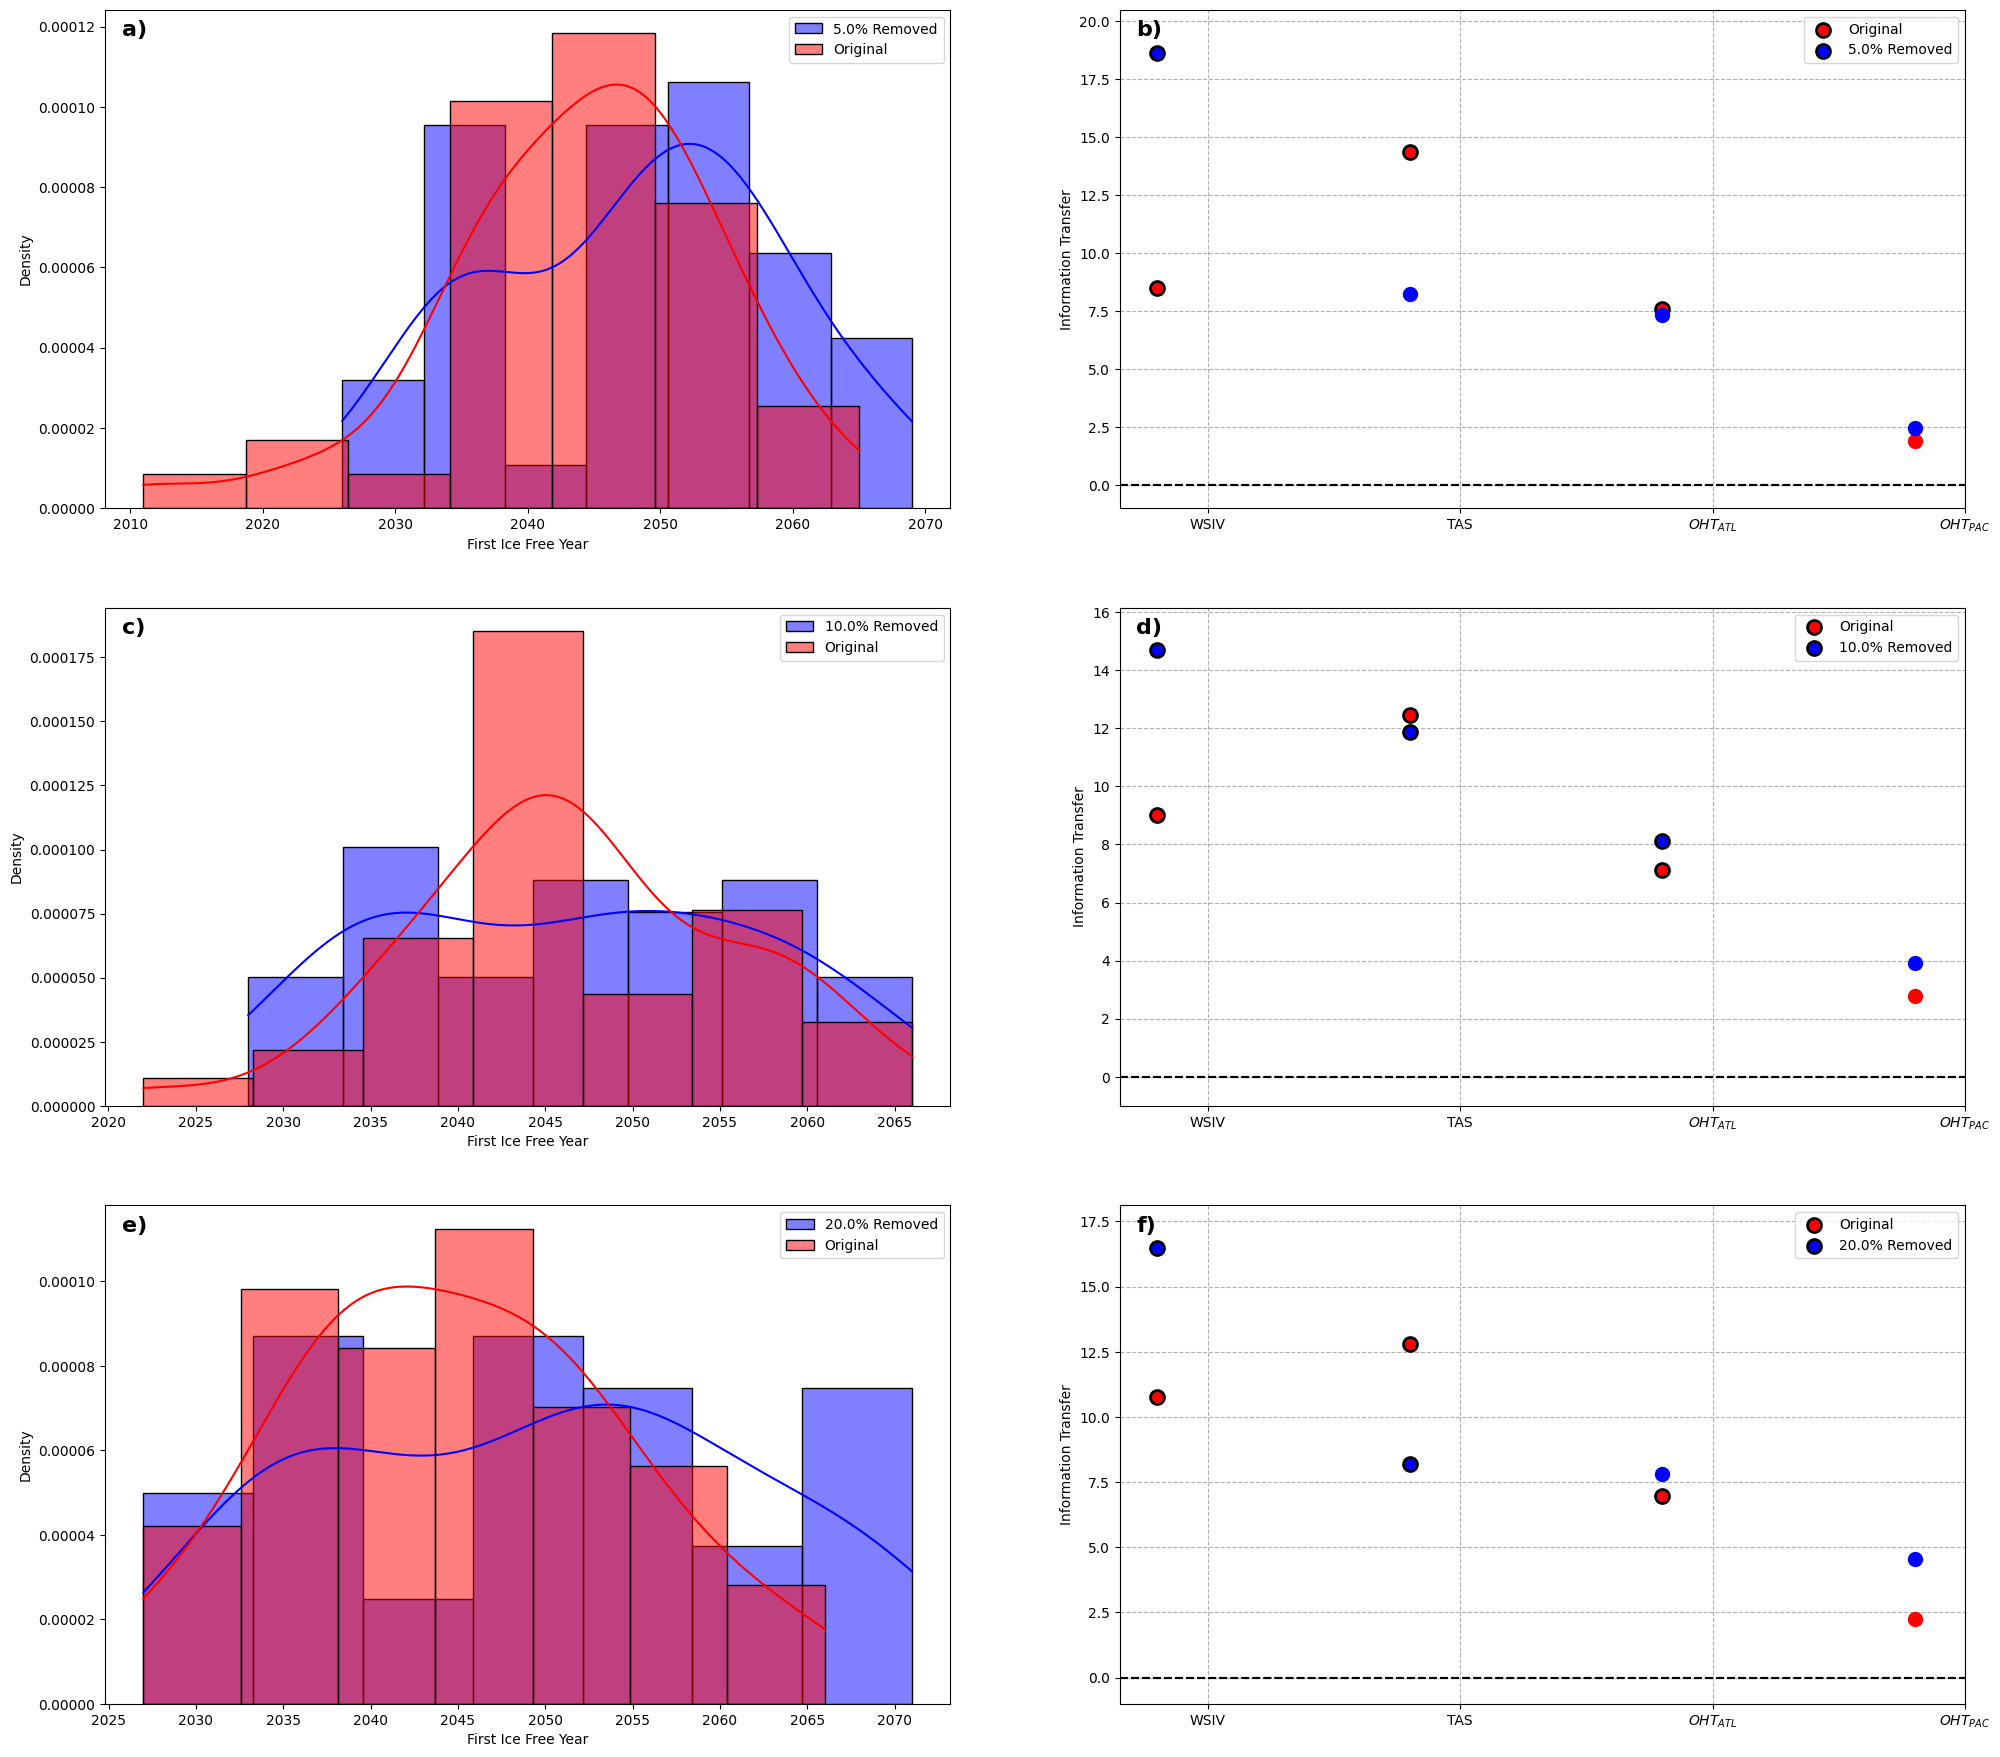

In [22]:
ps = [0.05, 0.1, 0.2]

_, axes = plt.subplots(nrows=3, ncols=2, figsize=(24,22))

for i, (p, ax_row) in enumerate(zip(ps, axes)):
    model_name = f"{p * 100}% Removed"
    model_colours = {
        model_name: "blue",
        "Original": "red"
    }
    output_005 = res_abs["tas"][p]

    y_005, test_members_005 = get_y_and_test_memebers(output_005)

    k[p] = test_members_005

    original_filtered_liang_res, pred_liang_res = prepare_liang_data(output_005, model_name, test_members_005, x_liang)

    icefree_year_dist_pred = calculate_first_icefree_year(output_005.y_pred_simul)
    icefree_year_dist = calculate_first_icefree_year(y_005)

    plot_densities_and_liang(
        icefree_year_dist_pred, icefree_year_dist,
        original_filtered_liang_res, pred_liang_res,
        model_name, liang_config, model_colours, pred_first=False,
        axes=ax_row, letter_i=i*2,
    )



Warm Cold

In [ ]:
model_name = "5% Removed"
model_colours = {
    model_name: "blue",
    "Original": "red"
}
output_005 = res_wc["tas"][0.05]

y_005, test_members_005 = get_y_and_test_memebers(output_005)

original_filtered_liang_res, pred_liang_res = prepare_liang_data(output_005, model_name, test_members_005, x_liang)

icefree_year_dist_pred = calculate_first_icefree_year(output_005.y_pred_simul)
icefree_year_dist = calculate_first_icefree_year(y_005)

plot_densities_and_liang(
    icefree_year_dist_pred, icefree_year_dist,
    original_filtered_liang_res, pred_liang_res,
    model_name, liang_config, model_colours, pred_first=False
)

In [ ]:
model_name = "10% Removed"
model_colours = {
    model_name: "blue",
    "Original": "red"
}
output_005 = res_wc["tas"][0.1]

y_005, test_members_005 = get_y_and_test_memebers(output_005)

original_filtered_liang_res, pred_liang_res = prepare_liang_data(output_005, model_name, test_members_005, x_liang)

icefree_year_dist_pred = calculate_first_icefree_year(output_005.y_pred_simul)
icefree_year_dist = calculate_first_icefree_year(y_005)

plot_densities_and_liang(
    icefree_year_dist_pred, icefree_year_dist,
    original_filtered_liang_res, pred_liang_res,
    model_name, liang_config, model_colours, pred_first=False
)

In [ ]:
model_name = "20% Removed"
model_colours = {
    model_name: "blue",
    "Original": "red"
}
output_005 = res_wc["tas"][0.2]

y_005, test_members_005 = get_y_and_test_memebers(output_005)

original_filtered_liang_res, pred_liang_res = prepare_liang_data(output_005, model_name, test_members_005, x_liang)

icefree_year_dist_pred = calculate_first_icefree_year(output_005.y_pred_simul)
icefree_year_dist = calculate_first_icefree_year(y_005)

plot_densities_and_liang(
    icefree_year_dist_pred, icefree_year_dist,
    original_filtered_liang_res, pred_liang_res,
    model_name, liang_config, model_colours, pred_first=False
)

#### Splitting

In [28]:
res = joblib.load(f"./icefreearcticml/outputs/abs_half_split_model_outputs.pkl")

TAS

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# plot_y_vs_pred(ax, output_lt, y_lt)

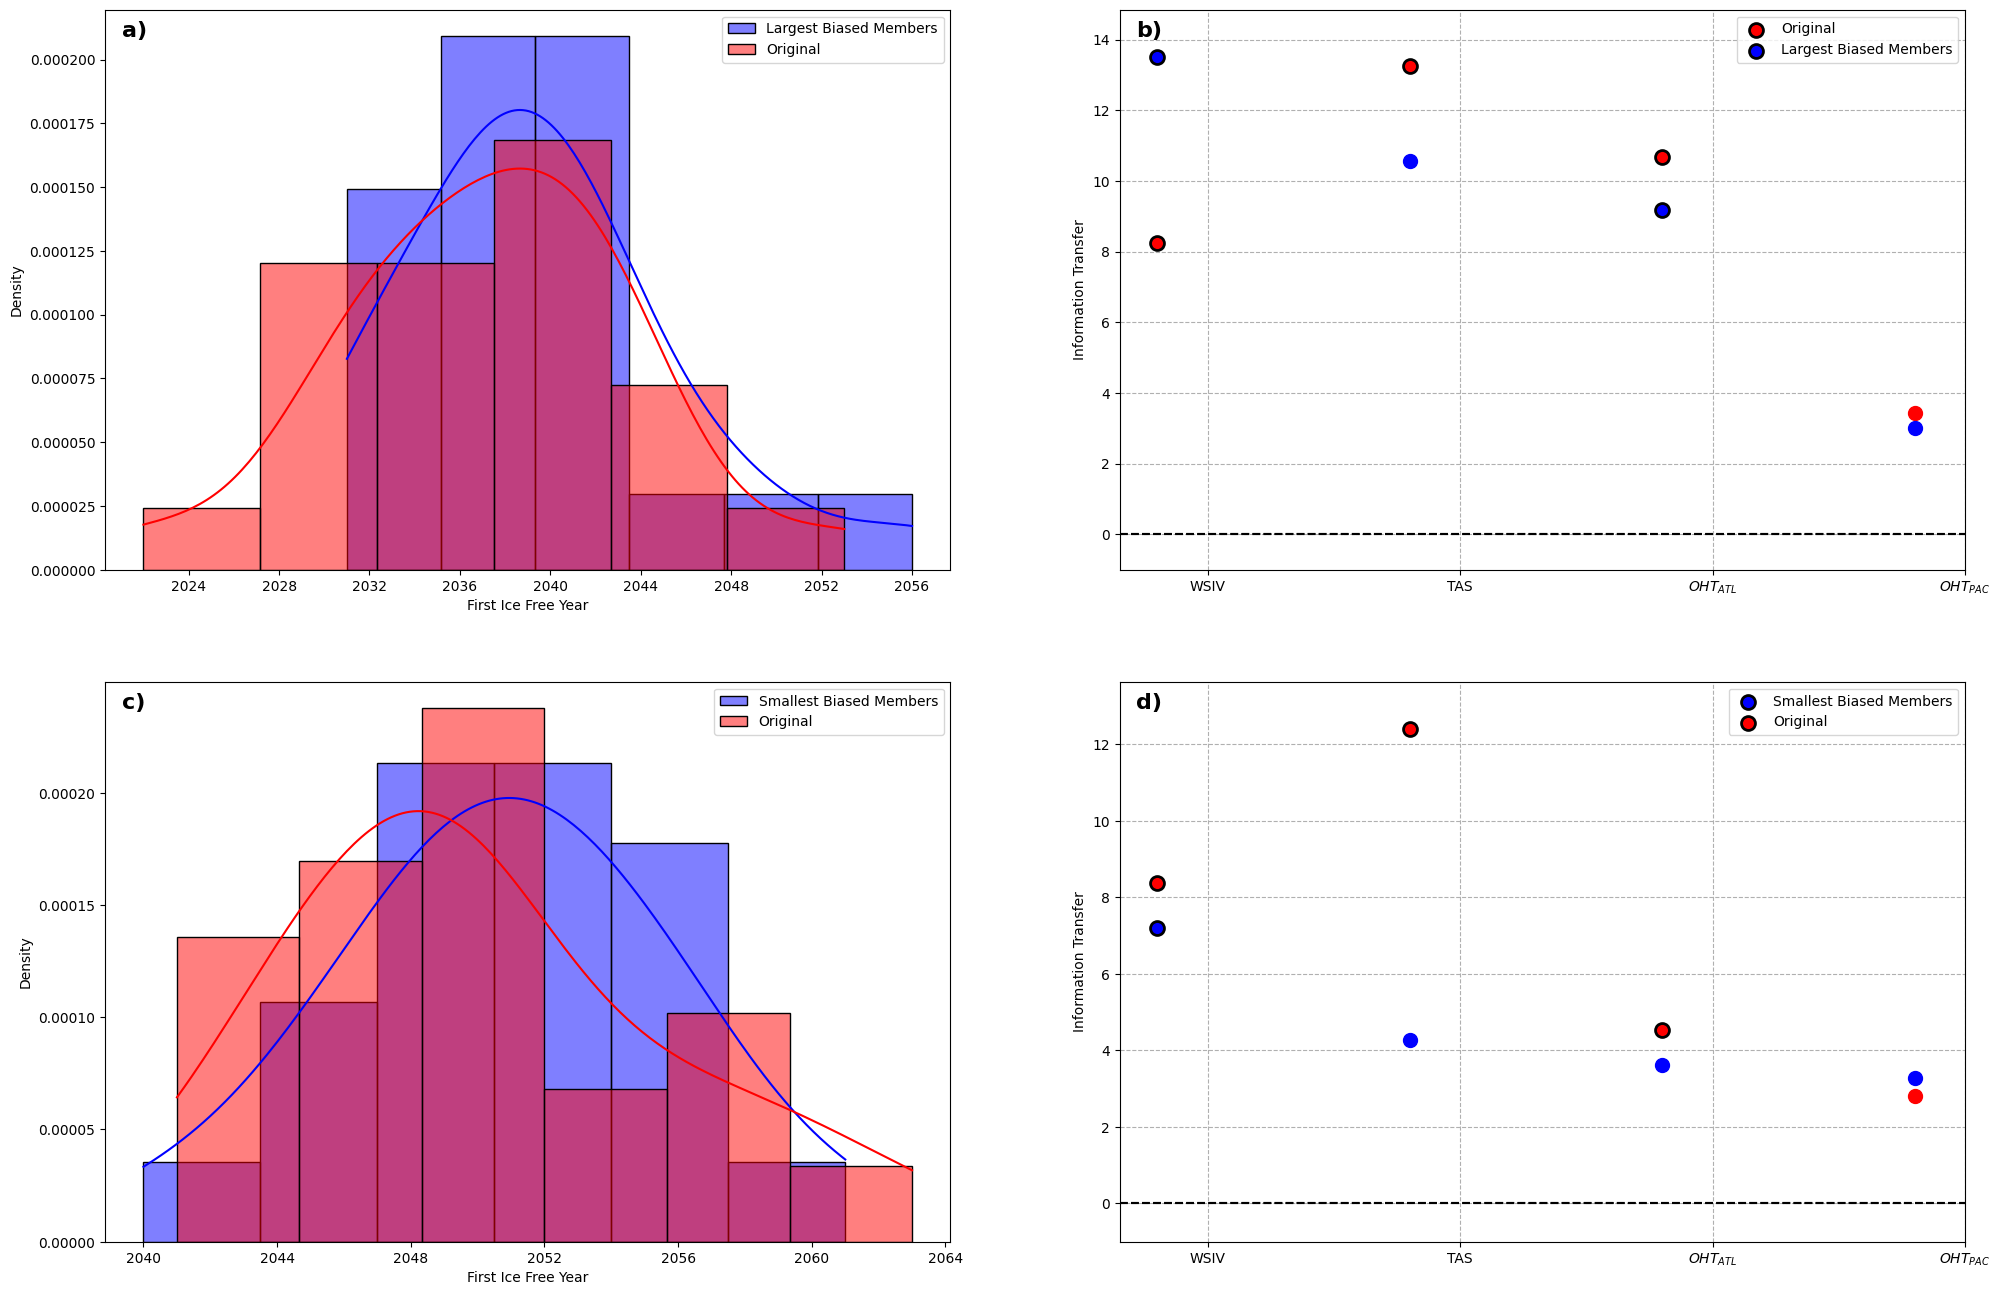

In [35]:
ks = {
    "gte": "Largest Biased Members",
    "lt": "Smallest Biased Members",
}

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,16))

for i, (k, ax_row) in enumerate(zip(ks, axes)):
    model_name = ks[k]
    model_colours = {
        model_name: "blue",
        "Original": "red"
    }
    output_005 = res["tas"][k]

    y_005, test_members_005 = get_y_and_test_memebers(output_005)

    original_filtered_liang_res, pred_liang_res = prepare_liang_data(output_005, model_name, test_members_005, x_liang)

    icefree_year_dist_pred = calculate_first_icefree_year(output_005.y_pred_simul)
    icefree_year_dist = calculate_first_icefree_year(y_005)

    plot_densities_and_liang(
        icefree_year_dist_pred, icefree_year_dist,
        original_filtered_liang_res, pred_liang_res,
        model_name, liang_config, model_colours, pred_first=i,
        axes=ax_row, letter_i=i*2,
    )



### Learning the Distribution Shift

In [ ]:
from icefreearcticml.icefreearcticml.learningdistribution import unmelt

In [ ]:
model_res = joblib.load("./icefreearcticml/")

In [ ]:
trends = model_res["trends"]

In [176]:
base_df = model_res["results"]["ssie"]
pred_df = unmelt(base_df[base_df["encoder_end_year"] == 2024])

# pred_df = pred_df.add(mean_trend.loc[pred_df.index], axis=0).clip(0)

test_members = pred_df.columns

pred_df = (pred_df + trends["ssie"][test_members]).clip(0).dropna()

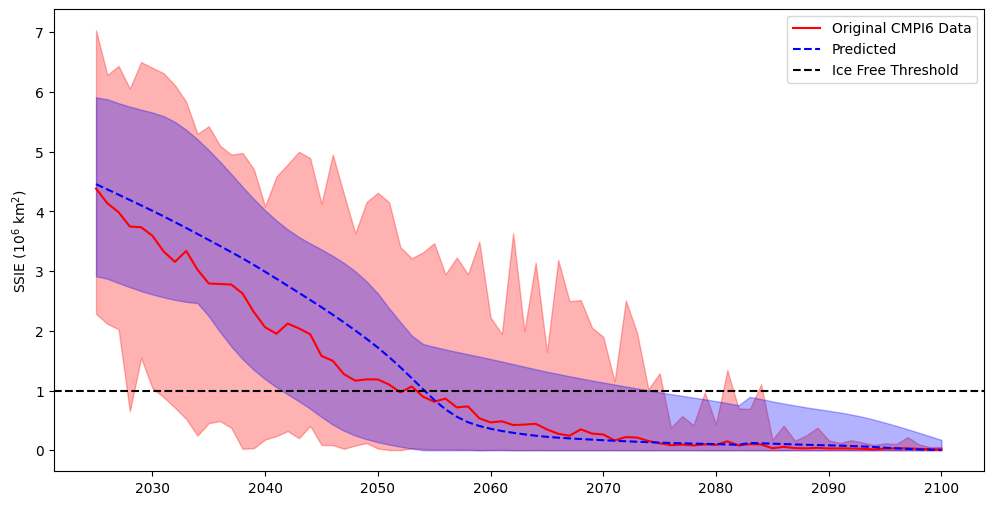

In [177]:
plt.figure(figsize=(12, 6))

og = model_data["ssie"]["all"][test_members].loc[pred_df.index]
label = "Original CMPI6 Data"
_ = plt.plot(og.mean(axis=1), color="red", label=label)
plt.fill_between(og.index, og.min(axis=1), og.max(axis=1), color="red", alpha=0.3)

label = "Predicted"
_ = plt.plot(pred_df.mean(axis=1), color="blue", ls="--", label=label)
plt.fill_between(pred_df.index, pred_df.min(axis=1), pred_df.max(axis=1), color="blue", alpha=0.3)

plt.axhline(y=1, color="black", ls="--", label="Ice Free Threshold")
plt.ylabel(VAR_YLABELS["ssie"])
plt.legend()

In [178]:
dt = 1
n_iter = 1000
liang_start = "1981-01-01"
liang_end = "2056-01-01"
x_liang = ["wsiv", "tas", "oht_atl", "oht_pac"]
y_liang = "ssie"

liang_config = LiangConfig(
    liang_start, liang_end, x_liang, y_liang, dt, n_iter,
)

In [186]:
pred_index = pred_df.index
model_data_filtered = {
    var: {"Original": model_dict["all"][test_members].loc[pred_index]} for var, model_dict in model_data.items()
}

model_name = "TFT"

pred_model_data = {}
for var in [*x_liang, "ssie"]:
    temp_df = model_res["results"][var]
    temp_df = unmelt(temp_df[temp_df["encoder_end_year"] == 1980])
    temp_df = (temp_df + trends[var][test_members]).dropna()
    pred_model_data[var] = {model_name: temp_df}

original_filtered_liang_res = calculate_all_liang_flows(model_data_filtered, liang_config, ["Original"])
pred_liang_res = calculate_all_liang_flows(pred_model_data, liang_config, [model_name])

/home/benjamin/icefreearcticml/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:9054: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)


In [187]:
icefree_year_dist_pred = calculate_first_icefree_year(pred_df)
icefree_year_dist = calculate_first_icefree_year(og)

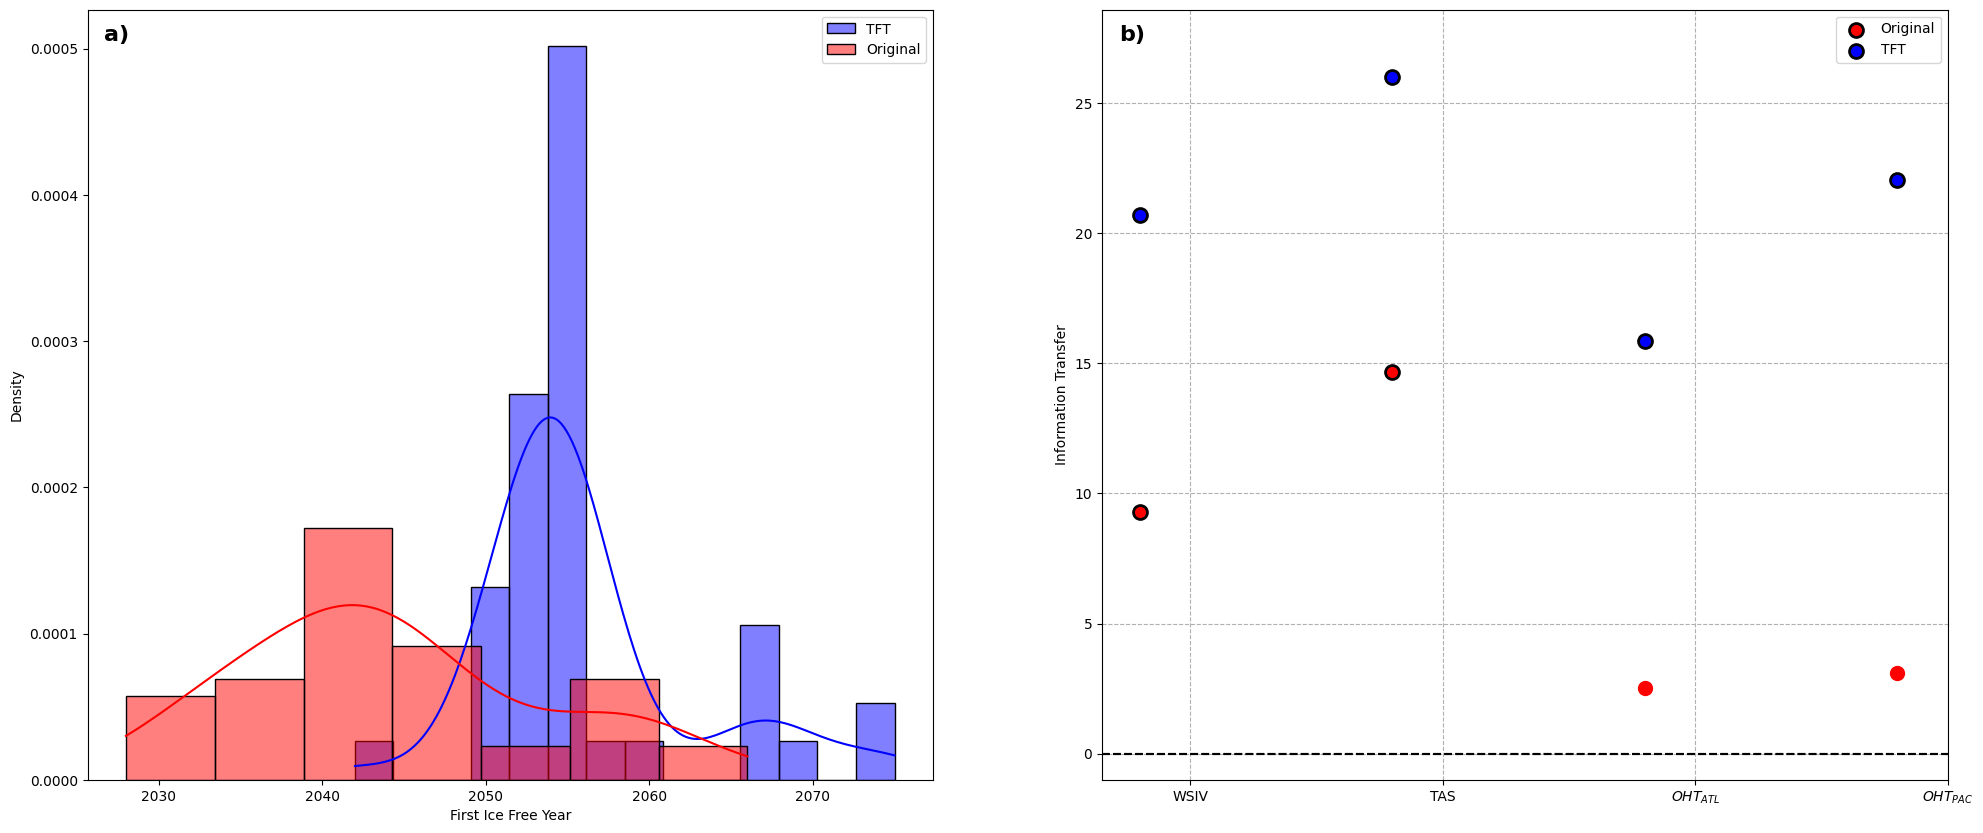

In [188]:
model_name = "TFT"
model_colours = {
    model_name: "blue",
    "Original": "red"
}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,10))

sns.histplot(icefree_year_dist_pred.values, kde=True, stat='density', color="blue", label=model_name, ax=axes[0])
sns.histplot(icefree_year_dist.values, kde=True, stat='density', color="red", label="Original", ax=axes[0])

plot_liang_tau_avgs(axes[1], original_filtered_liang_res, liang_config.x_liang, ["Original"], model_colours=model_colours)
plot_liang_tau_avgs(axes[1], pred_liang_res, liang_config.x_liang, [model_name], model_colours=model_colours)

axes[0].legend()
axes[0].set_xlabel("First Ice Free Year")
axes[0].text(0.02, 0.98, "a)", transform=axes[0].transAxes, 
            fontsize=16, fontweight='bold', va='top')

axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
            fontsize=16, fontweight='bold', va='top')
axes[1].legend()

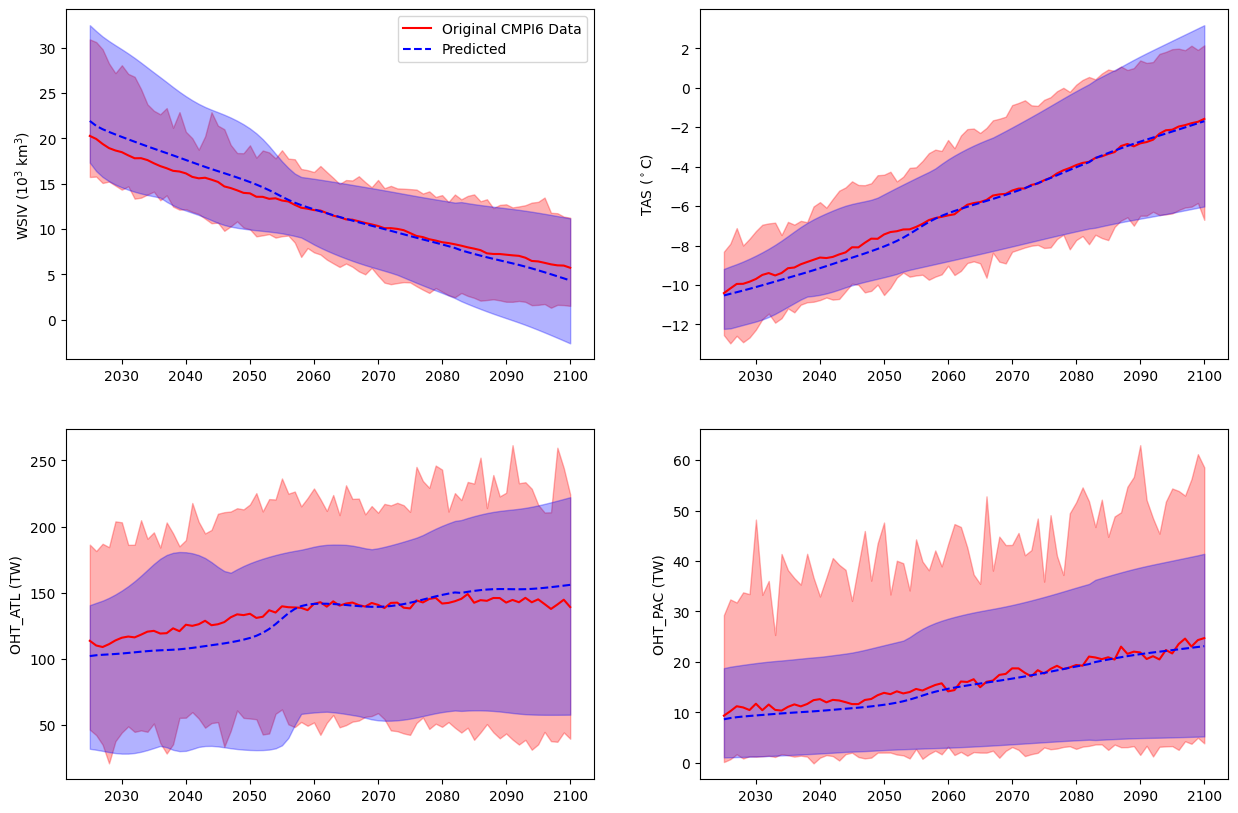

In [189]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for j, var in enumerate(x_liang):
    ax = axes[j]

    base_df = model_res["results"][var]
    pred_df = unmelt(base_df[base_df["encoder_end_year"] == 2024])
    pred_df = (pred_df + trends[var][test_members]).dropna()
    test_members = pred_df.columns

    og = model_data[var]["all"][test_members].loc[pred_df.index]
    label = "Original CMPI6 Data"
    _ = ax.plot(og.mean(axis=1), color="red", label=label)
    ax.fill_between(og.index, og.min(axis=1), og.max(axis=1), color="red", alpha=0.3)

    label = "Predicted"
    _ = ax.plot(pred_df.mean(axis=1), color="blue", ls="--", label=label)
    ax.fill_between(pred_df.index, pred_df.min(axis=1), pred_df.max(axis=1), color="blue", alpha=0.3)

    ax.set_ylabel(VAR_YLABELS[var])

    if j == 0:
        ax.legend()

In [92]:
bias_corrections = joblib.load("./icefreearcticml/outputs/bias_corrections.joblib")

obs_series = model_data["ssie"]["Observations"]
qm_data = bias_corrections["quantile_mapping"]
add_all(qm_data)

In [163]:
merged = None
for var in VARS:
    to_filter = bias_corrections["quantile_mapping"][var]["all"].fillna(0).apply(detrend) #.loc[obs_series.index]
    # if self.members_for_model is not None:
    #     to_filter = to_filter[self.members_for_model]
    res = get_melt(to_filter, var)
    if merged is None:
        merged = res
    elif var not in merged.columns:
        merged = merged.merge(res, on=["member", "time"])

merged["time"] = merged["time"].dt.year
all_data = merged

In [164]:
emul_data = all_data[all_data["member"].isin(train_config.test_data["member"].unique())]
emul_dataloader = get_timeseries_dataloader(train_config, emul_data, train=False)

In [165]:
model = model_res["model"]
emul_predictions = model.predict(emul_dataloader, return_index=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/benjamin/icefreearcticml/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


In [166]:
results = {}
for var, output in zip(train_config.y_var, emul_predictions.output):
    results[var] = predictions_to_dataframe(emul_predictions.index, output)

In [202]:
ssie_emul = results["ssie"]
ssie_emul = ssie_emul[ssie_emul["encoder_end_year"] == 2023]
ssie_emul = unmelt(ssie_emul)

ssie_emul = ssie_emul.add(trends["ssie"][test_members]).clip(0).dropna()

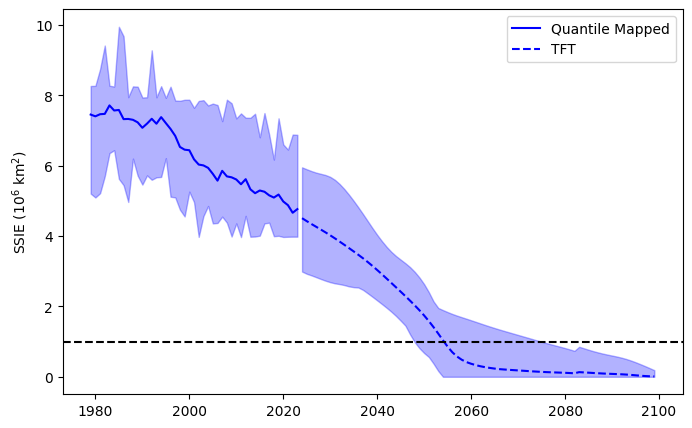

In [203]:
plt.figure(figsize=(8, 5))
og = bias_corrections["quantile_mapping"]["ssie"]["all"].loc[obs_series.index][test_members]

label = "Quantile Mapped"
_ = plt.plot(og.mean(axis=1), color="blue", label=label)
plt.fill_between(og.index, og.min(axis=1), og.max(axis=1), color="blue", alpha=0.3)

label = "TFT"
_ = plt.plot(ssie_emul.mean(axis=1), color="blue", label=label, ls="--")
plt.fill_between(ssie_emul.index, ssie_emul.min(axis=1), ssie_emul.max(axis=1), color="blue", alpha=0.3)

_ = plt.axhline(y=1, color="black", ls="--")
plt.ylabel(VAR_YLABELS["ssie"])
plt.legend()

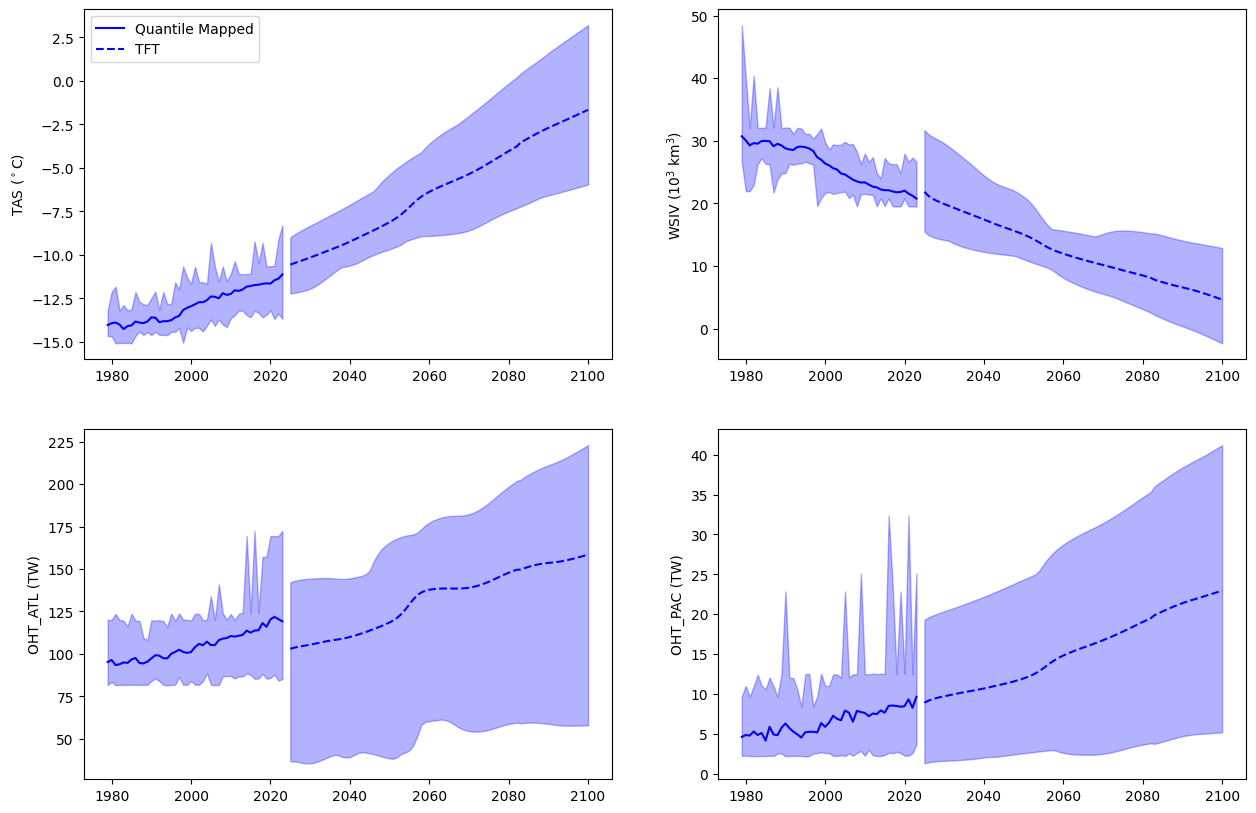

In [173]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for j, var in enumerate(VARS[1:]):
    ax = axes[j]

    og = bias_corrections["quantile_mapping"][var]["all"].loc[obs_series.index][test_members]
    label = "Quantile Mapped"
    _ = ax.plot(og.mean(axis=1), color="blue", label=label)
    ax.fill_between(og.index, og.min(axis=1), og.max(axis=1), color="blue", alpha=0.3)

    ssie_emul = results[var]
    ssie_emul = ssie_emul[ssie_emul["encoder_end_year"] == 2024]
    ssie_emul = unmelt(ssie_emul)
    ssie_emul = ssie_emul.add(trends[var][test_members]).dropna()

    label = "TFT"
    _ = ax.plot(ssie_emul.mean(axis=1), color="blue", label=label, ls="--")
    ax.fill_between(ssie_emul.index, ssie_emul.min(axis=1), ssie_emul.max(axis=1), color="blue", alpha=0.3)


    ax.set_ylabel(VAR_YLABELS[var])

    if j == 0:
        ax.legend()


In [ ]:
pred_index = pred_df.index
model_data_filtered = {
    var: {"Original": model_dict["all"][test_members]} for var, model_dict in model_data.items()
}

model_name = "QM + TFT"

pred_model_data = {}
for var in [*x_liang, "ssie"]:
    og = bias_corrections["quantile_mapping"][var]["all"].loc[obs_series.index][test_members]

    ssie_emul = results["ssie"]
    ssie_emul = ssie_emul[ssie_emul["encoder_end_year"] == 2023]
    ssie_emul = unmelt(ssie_emul)

    ssie_emul = ssie_emul.add(trends[var][test_members]).dropna()
    if var == "ssie":
        ssie_emul = ssie_emul.clip(0)

    pred_model_data[var] = {model_name: concat([og, ssie_emul])}

original_filtered_liang_res = calculate_all_liang_flows(model_data_filtered, liang_config, ["Original"])
pred_liang_res = calculate_all_liang_flows(pred_model_data, liang_config, [model_name])

In [212]:
icefree_year_dist_pred = calculate_first_icefree_year(pred_model_data["ssie"][model_name])
icefree_year_dist = calculate_first_icefree_year(model_data_filtered["ssie"]["Original"])

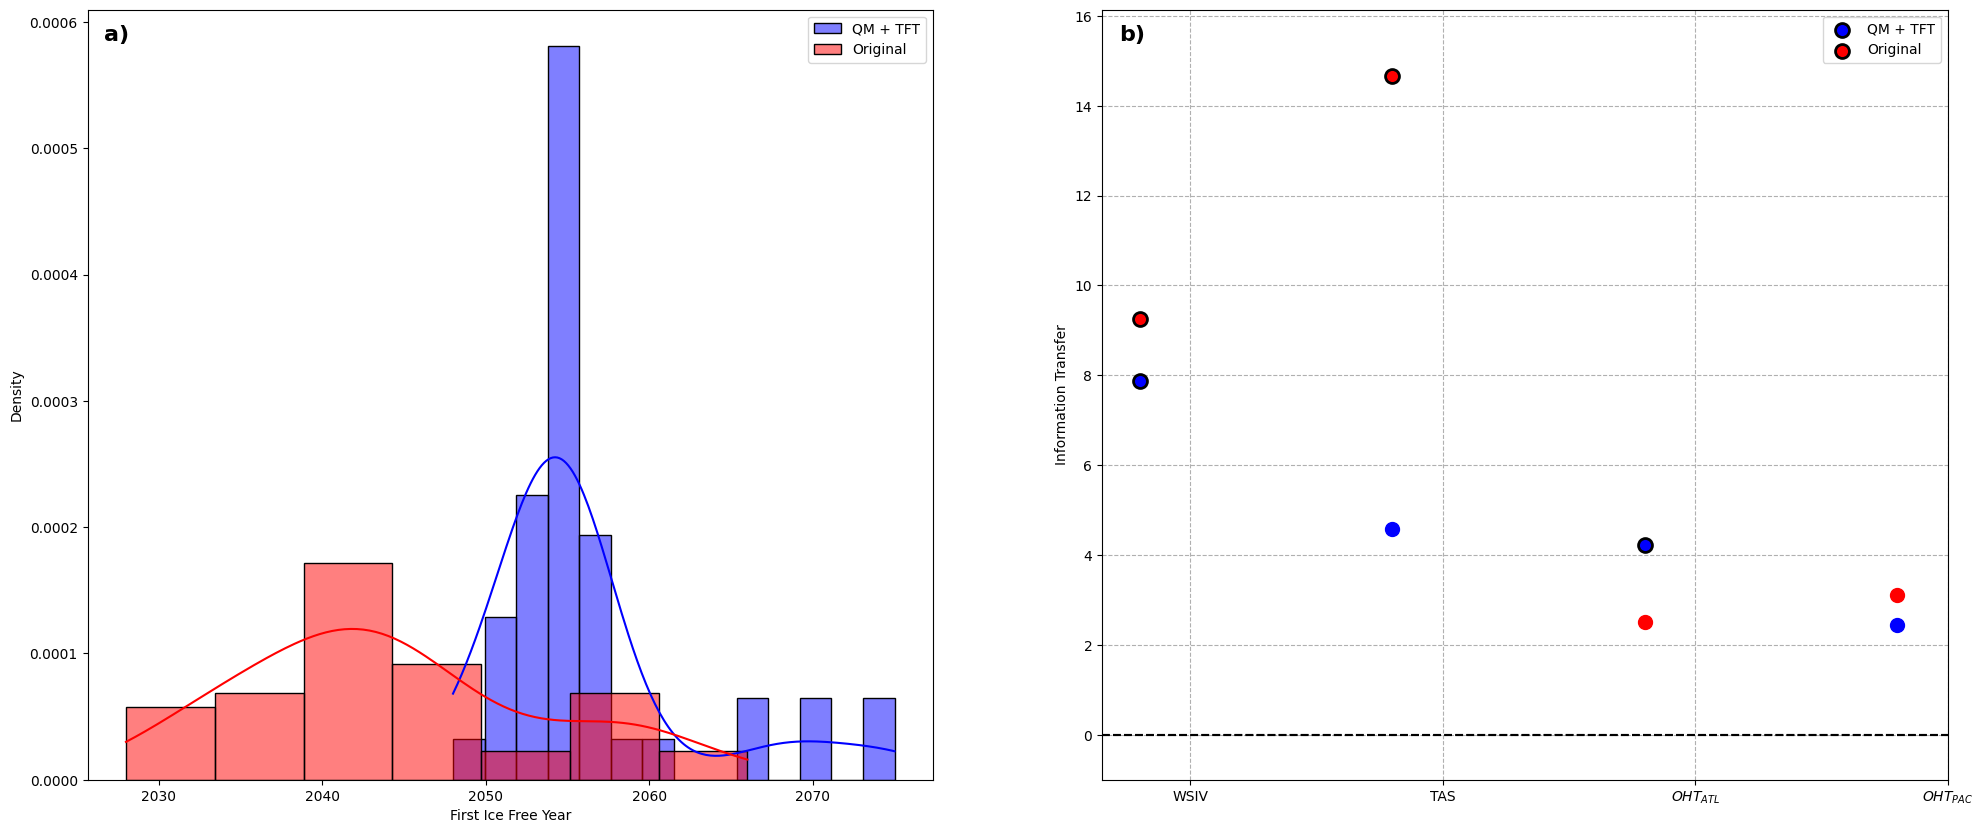

In [214]:
model_name = "QM + TFT"
model_colours = {
    model_name: "blue",
    "Original": "red"
}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,10))

sns.histplot(icefree_year_dist_pred.values, kde=True, stat='density', color="blue", label=model_name, ax=axes[0])
sns.histplot(icefree_year_dist.values, kde=True, stat='density', color="red", label="Original", ax=axes[0])

plot_liang_tau_avgs(axes[1], pred_liang_res, liang_config.x_liang, [model_name], model_colours=model_colours)
plot_liang_tau_avgs(axes[1], original_filtered_liang_res, liang_config.x_liang, ["Original"], model_colours=model_colours)

axes[0].legend()
axes[0].set_xlabel("First Ice Free Year")
axes[0].text(0.02, 0.98, "a)", transform=axes[0].transAxes, 
            fontsize=16, fontweight='bold', va='top')

axes[1].text(0.02, 0.98, "b)", transform=axes[1].transAxes, 
            fontsize=16, fontweight='bold', va='top')
axes[1].legend()